# **Comprehensive Carbonate Petrophysical Characterization Workflow:** 

## We have used the new hierarchical carbonate reservoir benchmarking case study created by Costa Gomes J, Geiger S, Arnold D to be used for reservoir characterization, uncertainty quantification and history matching(1)

**This Jupyter Notebook presents the Python Code and Documentation for a typical Carbonate Reservoir Characterization Workflow including the calculations of Chartbook Porosity, Lithology using Scipy Optimization and kNN estimations for Permeability and Thomeer Capillary Pressure (Pc) Parameters. The last step is to calculate Pc-based Bulk Volume Oil (BVO) based on the height above the Free Water Level (FWL) and formation fluid density differences to account for buoyancy. Accurate BVO is the results of level-by-level changes in the Thomeer parameters and Capillary Pressure curves at each level:**

>![Geolog_Image](Costa_field_characterization2.gif)

---
---
# 1) To Start, initialize the Notebook by running this entire Notebook using the >> in the menu line above:

- Then we will use the widget below to select the individual wells and log analysis parameters after initializing the widgets:


---
### Load dependencies:

The following section loads all of the Python libraries used in this notebook.



In [1]:
# -*- coding: utf-8 -*-
"""
Spyder Editor

This is a script file.
"""
import math
import openpyxl
import matplotlib.pyplot as plt
import pandas as pd

#import modin
#modin.config.Engine.put("Dask")
#import modin.pandas as pd
import numpy as np
from scipy.optimize import minimize
import lasio
import ipywidgets as widgets

%matplotlib inline

import panel as pn
pn.extension()


import time
#timecosts = []
s_time = time.time()


# Use the widgets below to **Select the Well** that you want to analyze and declare the type of Neutron log that you are using: 
>### The map below shows the location of each well on the structure. Determine the well that
>### you want to use from the map, and then go one cell below to select the well from the widget.
>
>![HW_well_map-2-2.png](HW_well_map-2-2.png)
>
## Select the well from the widget below:

In [2]:
'''
Which Well ?
'''

import panel as pn
pn.extension()

#menu_items = [('Option A', 'a'), ('Option B', 'b'), ('Option C', 'c'), None, ('Help', 'help')]
menu_items_wells = [('HW-3', 'las = lasio.read("./data/HW-3.las");elev_meas_ref = 160'), 
              ('HW-4', 'las = lasio.read("./data/HW-4.las");elev_meas_ref = 29'), 
              ('HW-5', 'las = lasio.read("./data/HW-5.las");elev_meas_ref = 36'), 
              ('HW-6', 'las = lasio.read("./data/HW-6.las");elev_meas_ref = 49'),
              ('HW-7', 'las = lasio.read("./data/HW-7.las");elev_meas_ref = 367'),
              ('HW-8', 'las = lasio.read("./data/HW-8.las");elev_meas_ref = 416'),
              ('HW-9', 'las = lasio.read("./data/HW-9.las");elev_meas_ref = 492'),
              ('HW-10','las = lasio.read("./data/HW-10.las");elev_meas_ref = 397'),
              ('HW-24','las = lasio.read("./data/HW-24.las");elev_meas_ref = 426'),
              ('HW-25','las = lasio.read("./data/HW-25.las");elev_meas_ref = 386'),
              ('HW-26','las = lasio.read("./data/HW-26.las");elev_meas_ref = 375'),
              ('HW-27','las = lasio.read("./data/HW-27.las");elev_meas_ref = 453'),
              ('HW-28','las = lasio.read("./data/HW-28.las");elev_meas_ref = 430'),
              ('HW-29','las = lasio.read("./data/HW-29.las");elev_meas_ref = 466'),
              ('HW-30','las = lasio.read("./data/HW-30.las");elev_meas_ref = 590'),
              ('HW-31','las = lasio.read("./data/HW-31.las");elev_meas_ref = 417'),
              ('HW-32','las = lasio.read("./data/HW-32.las");elev_meas_ref = 441'),
                    
                    
                    
              #('CO3','las = lasio.read("./data/co3.las");elev_meas_ref = 90'),  
                    
                    
                    
                    
              None, ('Help', 'Choose a single well. From START POINT, Run Selected Cell and All Below')]

menu_button = pn.widgets.MenuButton(name='Choose Well', items=menu_items_wells, button_type='primary')

pn.Column(menu_button, height=100)


text = pn.widgets.TextInput(value='las = lasio.read("./data/HW-10.las");elev_meas_ref = 397')

#def b(event):
#    text.value = f'Chose well: "{event.new}"'

def b(event):
    text.value = f'{event.new}'
    #text.value = exec.event.new
    
    #text.value = f'Chose well: "{event.new}"'    
    
menu_button.on_click(b)

pn.Row(menu_button, text, height=200, width=1000)






Row(height=200, sizing_mode='fixed', width=1000)
    [0] MenuButton(button_type='primary', items=[('HW-3', 'las = lasio.rea...], name='Choose Well')
    [1] TextInput(value='las = lasio.read("./data/...)

## Select the SLB **Neutron-Density Chart** that you want to use to calculate PHIT:

**We will calculate a Neutron Porosity vs. Bulk Density Cross-Plot Total porosity (PHIT) using the Schlumberger CNL or TNPH Charts. It is important to use the proper Neutron chart for either fresh or saline fluid densities as specified. The Neutron logs should also be on limestone matrix units to be used with these charts.** 


In [3]:
rdbuttons = widgets.RadioButtons(
    options = ['CNL_1pt0','CNL_1pt1','TNPH_1pt0', 'TNPH_1pt19'],
    value='CNL_1pt1',
    layout={'widdt':'max-content'},
    description = 'Neutron Log',
    disabled=False
)


rdbuttons

RadioButtons(description='Neutron Log', index=1, options=('CNL_1pt0', 'CNL_1pt1', 'TNPH_1pt0', 'TNPH_1pt19'), …

## Run cell below to set Well and Chartbook options:

In [4]:
mycode = text.value
exec(mycode)

print()
print('Well Data being used with elev_meas_ref:', text.value)
print()

chart=rdbuttons.value
print('Neutron-Density Chart =', chart)
print()


Well Data being used with elev_meas_ref: las = lasio.read("./data/HW-10.las");elev_meas_ref = 397

Neutron-Density Chart = CNL_1pt1



# 1) Read In Well Log Data from las File using Lasio
>
># 1st **START POINT** 
>
>
>## A **2nd START POINT** will be needed after setting Electrical Properties and Rw as well as determining the Lithology options using the 2 **Interactive Plots** found about a half of the way down in this notebook.
>
>### After initializing the Notebook by running the entire Notebook once using >> in the menu line, then select any well you want to analyze, choose Neutron-Density chart, lithology options and then run all cells below using "Cells or Run", and then "Run this cell and all below".
>
>
>![Run](cells_run_below.png)
>
**Well Header Data:**

---

### The following section loads the Well Log Data using Lasio Created by **Andy McDonald.** 
  
This portion of the notebook illustrates how to load data in from a LAS file and carry out a basic QC of the data before plotting it on a log plot.

In [5]:
#las = lasio.read("./data/HW-3.las");elev_meas_ref = 160
#las = lasio.read("./data/HW-4.las");elev_meas_ref = 29
#las = lasio.read("./data/HW-5.las");elev_meas_ref = 36
#las = lasio.read("./data/HW-6.las");elev_meas_ref = 49
#las = lasio.read("./data/HW-7.las");elev_meas_ref = 367
#las = lasio.read("./data/HW-8.las");elev_meas_ref = 416
#las = lasio.read("./data/HW-9.las");elev_meas_ref = 492
#las = lasio.read("./data/HW-10.las");elev_meas_ref = 397
#las = lasio.read("./data/HW-24.las");elev_meas_ref = 426
#las = lasio.read("./data/HW-25.las");elev_meas_ref = 386
#las = lasio.read("./data/HW-26.las");elev_meas_ref = 375
#las = lasio.read("./data/HW-27.las");elev_meas_ref = 453
#las = lasio.read("./data/HW-28.las");elev_meas_ref = 430
#las = lasio.read("./data/HW-29.las");elev_meas_ref = 466
#las = lasio.read("./data/HW-30.las");elev_meas_ref = 590
#las = lasio.read("./data/HW-31.las");elev_meas_ref = 417
#las = lasio.read("./data/HW-32.las");elev_meas_ref = 441

## Interrogate your Lasion data:

In [6]:
for item in las.well:
    print(f"{item.descr} ({item.mnemonic}): {item.value}")

 (STRT): 8150.0
 (STOP): 8630.0
 (STEP): 0.5
 (NULL): -999.25
COMPANY (COMP): 
WELL (WELL): HW-10
FIELD (FLD): COSTA
LOCATION (LOC): 
SERVICE COMPANY (SRVC): 
ss} (DATE): 2018-02-06 14:55:39   : Log Export Date {yyyy-MM-dd HH:mm
PROVINCE (PROV): 
UNIQUE WELL ID (UWI): HW-10
API NUMBER (API): 


In [7]:
for curve in las.curves:
    print(curve.mnemonic)

DEPT
GR
RHOB
NPHI
DT
PHIE
RT
SW
SO
CORE_POR
CORE_PERM


In [8]:
las.keys()

['DEPT',
 'GR',
 'RHOB',
 'NPHI',
 'DT',
 'PHIE',
 'RT',
 'SW',
 'SO',
 'CORE_POR',
 'CORE_PERM']

In [9]:
df_log = las.df()

In [10]:
df_log.head()

,GR,RHOB,NPHI,DT,PHIE,RT,SW,SO,CORE_POR,CORE_PERM
DEPT,,,,,,,,,,
8440.0,31.66,2.73,0.07,NaN,0.0,17.62,NaN,NaN,NaN,NaN
8440.5,30.61,2.73,0.06,NaN,0.0,19.01,NaN,NaN,NaN,NaN
8441.0,29.37,2.72,0.06,NaN,0.0,20.33,NaN,NaN,NaN,NaN
8441.5,28.05,2.73,0.05,NaN,0.0,21.58,NaN,NaN,NaN,NaN
8442.0,27.10,2.73,0.05,NaN,0.0,22.79,NaN,NaN,NaN,NaN


In [11]:
df_log['GR']

DEPT
8440.0    31.66
8440.5    30.61
8441.0    29.37
8441.5    28.05
8442.0    27.10
          ...  
8628.0    23.40
8628.5    27.49
8629.0    32.21
8629.5    33.37
8630.0    29.32
Name: GR, Length: 381, dtype: float64

In [12]:
for count, curve in enumerate(las.curves):
    print(f"Curve: {curve.mnemonic}, Units: {curve.unit}, Description: {curve.descr}")
print(f"There are a total of: {count+1} curves present within this file")

Curve: DEPT, Units: ft, Description: DEPTH
Curve: GR, Units: gAPI, Description: GR
Curve: RHOB, Units: g/cm3, Description: RHOB
Curve: NPHI, Units: ft3/ft3, Description: NPHI
Curve: DT, Units: us/ft, Description: DT
Curve: PHIE, Units: ft3/ft3, Description: PHIE
Curve: RT, Units: ohm.m, Description: RT
Curve: SW, Units: , Description: SW
Curve: SO, Units: , Description: SO
Curve: CORE_POR, Units: ft3/ft3, Description: CORE_POR
Curve: CORE_PERM, Units: mD, Description: CORE_PERM
There are a total of: 11 curves present within this file


In [13]:
df_log.describe()

,GR,RHOB,NPHI,DT,PHIE,RT,SW,SO,CORE_POR,CORE_PERM
count,381.000000,381.000000,381.000000,0.0,381.000000,381.000000,160.000000,160.000000,311.000000,311.000000
mean,12.346719,2.410236,0.187402,NaN,0.182047,4.944278,0.669063,0.330937,23.070740,12.134534
std,6.704469,0.165094,0.079996,NaN,0.092130,9.043167,0.161995,0.161995,4.518222,33.281485
min,5.370000,2.250000,0.020000,NaN,0.000000,0.220000,0.380000,0.000000,8.710000,0.040000
25%,8.610000,2.290000,0.150000,NaN,0.140000,0.440000,0.540000,0.200000,21.075000,1.365000
50%,9.390000,2.330000,0.230000,NaN,0.230000,1.030000,0.670000,0.330000,24.830000,2.770000
75%,11.980000,2.480000,0.250000,NaN,0.250000,2.670000,0.800000,0.460000,26.325000,5.950000
max,33.940000,2.750000,0.270000,NaN,0.270000,38.180000,1.000000,0.620000,31.800000,345.340000


In [14]:
df_log.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 381 entries, 8440.0 to 8630.0
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   GR         381 non-null    float64
 1   RHOB       381 non-null    float64
 2   NPHI       381 non-null    float64
 3   DT         0 non-null      float64
 4   PHIE       381 non-null    float64
 5   RT         381 non-null    float64
 6   SW         160 non-null    float64
 7   SO         160 non-null    float64
 8   CORE_POR   311 non-null    float64
 9   CORE_PERM  311 non-null    float64
dtypes: float64(10)
memory usage: 32.7 KB


## Visualising Data Extent (from Andy McDonald):

Instead of the summary provided by the pandas describe() function, we can create a visualisation using matplotlib. Firstly, we need to work out where we have nulls (nan values). We can do this by creating a second dataframe and calling .notnull() on our well dataframe.  
  
As this returns a boolean (True or False) for each depth, we need to multiply by 1 to convert the values from True and False to 1 and 0 respectively.

In [15]:
well_nan = df_log.notnull() * 1

In [16]:
well_nan.head()

,GR,RHOB,NPHI,DT,PHIE,RT,SW,SO,CORE_POR,CORE_PERM
DEPT,,,,,,,,,,
8440.0,1,1,1,0,1,1,0,0,0,0
8440.5,1,1,1,0,1,1,0,0,0,0
8441.0,1,1,1,0,1,1,0,0,0,0
8441.5,1,1,1,0,1,1,0,0,0,0
8442.0,1,1,1,0,1,1,0,0,0,0


We can now create a summary plot of the missing data.



HW-10


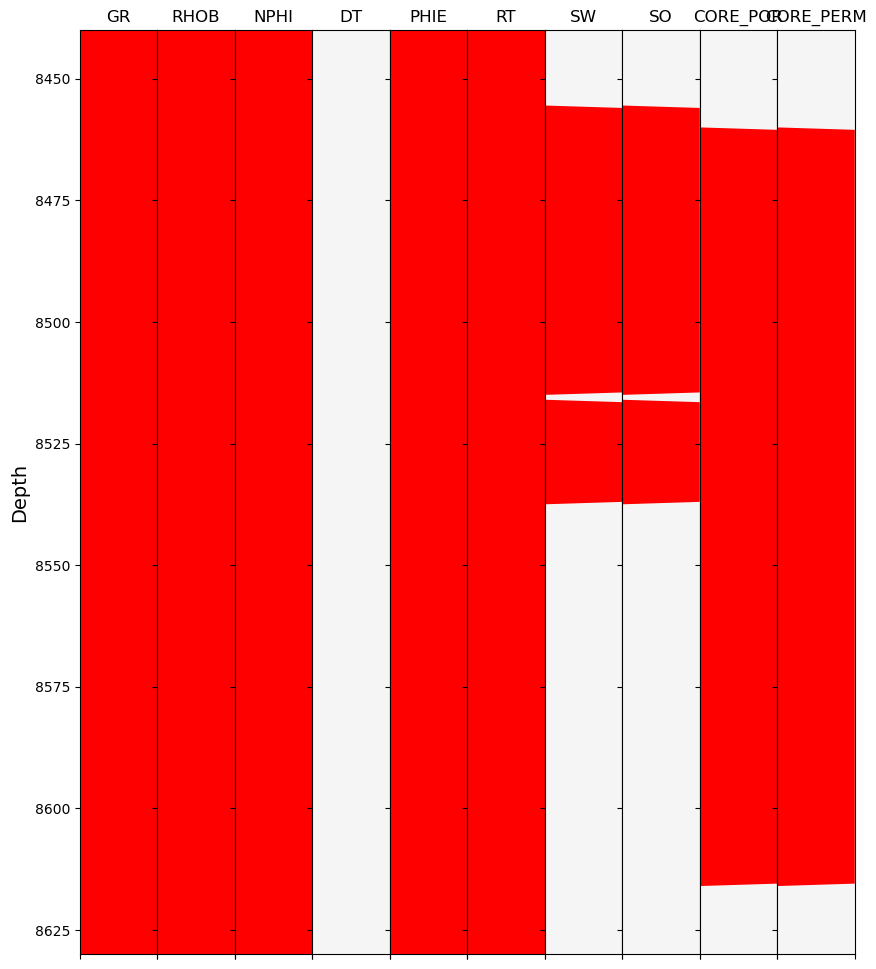

In [17]:
fig = plt.subplots(figsize=(10,12))
wellname=las.well.well.value
print()
print()
print(wellname)
#fig.suptitle('Data Extent: %s'%wellname, fontsize=24, color='blue')
#fig.subplots_adjust(top=0.94, wspace=0.05, hspace =0.1)



#Set up the plot axes
ax1 = plt.subplot2grid((1,10) , (0,0), rowspan=1, colspan = 1) 
ax2 = plt.subplot2grid((1,10) , (0,1), rowspan=1, colspan = 1)
ax3 = plt.subplot2grid((1,10) , (0,2), rowspan=1, colspan = 1)
ax4 = plt.subplot2grid((1,10) , (0,3), rowspan=1, colspan = 1)
ax5 = plt.subplot2grid((1,10) , (0,4), rowspan=1, colspan = 1)
ax6 = plt.subplot2grid((1,10) , (0,5), rowspan=1, colspan = 1)
ax7 = plt.subplot2grid((1,10) , (0,6), rowspan=1, colspan = 1)
ax8 = plt.subplot2grid((1,10) , (0,7), rowspan=1, colspan = 1)
ax9 = plt.subplot2grid((1,10) , (0,8), rowspan=1, colspan = 1)
ax10 = plt.subplot2grid((1,10), (0,9), rowspan=1, colspan = 1)


columns = well_nan.columns
axes = [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10]

for i, ax in enumerate(axes):
    ax.plot(well_nan.iloc[:,i], well_nan.index, lw=0)
    #ax.set_ylim(3000, 0)
    ax.set_ylim(max(las["DEPT"]),min(las["DEPT"]))
    ax.set_xlim(0, 1)
    ax.set_title(columns[i])
    ax.set_facecolor('whitesmoke')
    ax.fill_betweenx(well_nan.index, 0, well_nan.iloc[:,i], facecolor='red')
    # Remove tick labels from each subplot
    if i > 0:
        plt.setp(ax.get_yticklabels(), visible = False)
    plt.setp(ax.get_xticklabels(), visible = False)

ax1.set_ylabel('Depth', fontsize=14)

plt.subplots_adjust(wspace=0)

plt.show()

## Assign log curves from las file:

In [18]:
Dep = las['DEPT']
CNL  = las['NPHI']
RHOB = las['RHOB']
#RHOMAA = las['RHOMAA']
Porosity = las['PHIE']
gr       = las['GR']
ild      = las['RT']

---
---
# Costa's Carbonate Reservoir Characterization Workflow being used in this Notebook:

In this GitHub repository we have used a new, comprehensive reservoir characterization database from Costa, Geiger and Arnold(1) We employed all the available well logs, Routine Core Analysis (RCA) and Special Core Analysis (SCAL and implemented our normal carbonate reservoir characterization workflow as discussed by Phillips (2). For this repository we did not use the 3D static or dynamic models, but we did use the time-series dynamic production and formation pressure data by well in Spotfire to better understand the dynamic aspects of the reservoir too. This is a rich dataset that needs to be explored further, more than what is presented in the scope of this project. 

The RCA and SCAL core data as well as the 17 well logs provided as las files were used extensively in our Petrophysical evaluation. These data are all in a Geolog project that is included in this repository. The following layout depth plot display shows a typical well from the field and the analysis performed on each well. 

![Geolog_Image](Results.png)

The process used in this repository follows a tried and proven workflow as described by Phillips et al. (2) in the characterization of an Arab D carbonate reservoirs from Saudi Arabia. Core Porosity, Permeability, Petrophysical Rock Types (PRT), Capillary Pressure and capillary pressure-based saturations are all estimated or calculated within this workflow. Just as in previous studies, the core analysis database was used extensively as the foundation and calibration to these petrophysical interpretations. 

Costa provided 110 High Pressure Mercury Injection (HPMI) core samples with RCA Porosity and Permeability. We performed Thomeer Parameter Analysis on each HPMI sample to establish our own, reservoir specific Thomeer Parameter Capillary Pressure core database used to mode saturations. In Geolog we fit the Thomeer hyperbola to all 110 HPMI samples and established the Thomeer parameters for each sample. We used python loglan code to load the High-Pressure Mercury Injection (HPMI) Core data directly from the Costa SCAL dataset into a Geolog Well and then modeled the HPMI data using the Thomeer parameters fitting the Thomeer hyperbola to each HPMI sample. This portion of the Geolog project serves an example as to how to build your own reservoir-specific core calibration database for their own Reservoir Characterization studies. 

![Geolog_Image]( Thomeer_Parameter_fitting.gif)

### Suggested Carbonate Workflow:
The following workflow and processing are suggested to interrogate, process, interpret and model the petrophysical properties for this benchmark carbonate reservoir using Costa's RCA and High-Pressure Mercury Injection core database as calibration. The workflow consists of the following steps:

1) Interrogate the Well Log data and Costa calibration data using standard Geolog layouts, cross plots, and histograms; and then use a python loglan featuring Altair, which is interactive software driven from a Geolog Module Launcher.

##### Altair used to Interrogate the Costa Capillary Pressure curves and Petrophysical Rock Types (PRTs):

![Geolog_Image](Costa_Pc2.gif)

2) Normally we would run MultiMin for a solid log analysis model using the typical minerals found in this reservoir; Limestone, Dolomite, and Illite. With MultiMin we always use environmentally corrected log data, calculating the uncertainties for each log curve employed in the analysis. However, to make this dataset more universal, we have employed python to perform our deterministic log analysis of the 17 HW wells. This code is provided in the Geolog project. We received these data as las files with a text file of log header data including X,Y locations, KB elevation and TD.  There were no directional survey data provided, so at this point we are assuming these wells to be vertical, and TVDss was calculated accordingly. 

3) Use available core data from the representative reservoir/field to build a petrophysical model to estimate permeability for all wells in field using Geolog's Facimage. Our plan is to include a python loglan too using kNN with normalized input data that is weighted by Euclidean distances for each of the nearest neighbors to estimate permeability for each well. 

4) Using the kNN estimated permeability and calculated Total Porosity (PHIT) from our log analysis, we queried Costa's core database to predict the following Petrophysical results:

- Thomeer Capillary Pressure parameters (Pdi, Gi and BVocci) for each pore system, i, over the entire reservoir interval for Capillary Pressure-based saturations
- Estimate the most dominant pore throat diameter at each level in the well calculated from the Thomeer parameters G and Pd. This exact mode of the pore throat distribution is calculated using the following equation:

	 	*Mode of Pore Throat Distribution (microns) = exp(-1.15 * G1) * (214/Pd1)*

This exact Mode of the Pore Throat Distribution (PTD) is what Winland is trying to accomplish with r35 and Amaefule with FZI; however, they are not exact. The Mode of the PTD calculated from the Buiting equation is taken directly from the Capillary Pressure data and is the exact mode that correlates to other petrophysical parameters extremely well. 

We used this mode to partition our data into Petrophysical Rock Types. If the Mode > 2 microns, then the PRT was a Macro porous rock. If the Mode > 0.1 micron and less that 2 microns, then this was Meso porous rock. If the Mode < 0.1 microns, then this rock was Micro porous rock.


5) Use the Thomeer Capillary Pressure parameters to model saturations based on the buoyancy due to fluid density differences at the height above the Free Water Level (FWL). In this instance we compare the Bulk Volume Oil (BVO) from our analysis vs. BVO from Thomeer-based capillary pressure saturations. We have used BVO since BVO is pore volume weighted, and Sw is not.

We did perform a Free Water Level (FWL) search for each well. We use the Thomeer parameters to model Capillary Pressure based saturations as shown below:

![Geolog_Image](Thomeer_sats.png)

We vary the FWL from the highest potential FWL elevation down to the lowest potential FWL elevation for the reservoir and pick the FWL where the error between the BVO on logs vs. Capillary Pressure are at a minimum. 

![Geolog_Image](fwl_search.gif)

This is an example of the single well output from a typical FWL search. The FWL search was performed on all wells in the study.

![Geolog_Image](FWLSearch.png)

Not all wells are useful in establishing the FWL. A few of the wells were too high where all we really were estimating was the Base of Reservoir (BOR) for those wells. There were also a few wells that were near 100% wet, and they were not used to establish the FWL surface. Eliminating these wells allowed us to establish the following FWL surface for this reservoir:

![Geolog_Image](FWL_Surface.png)

Our estimated FWL surface is a plane but tilted with a high of 8178 feet TVDss on the West dipping to the East to a maximum FWL elevation of 8214 feet TVDss. Tilted FWL’s are quite prevalent in Saudi Arabia due to dynamic aquifer pressures, tilted structures and even subduction. This FWL Surface was then used with the estimated Thomeer parameters on each well to calculate the final Capillary Pressure based saturations for each well. 



---
### RESOURCES:
https://researchportal.hw.ac.uk/en/datasets/costa-model-hierarchical-carbonate-reservoir-benchmarking-case-st

https://github.com/Philliec459/Geolog-Used-to-Model-Thomeer-Parameters-from-High-Pressure-Mercury-Injection-Data

https://github.com/Philliec459/Geolog-Used-to-Automate-the-Characterization-Workflow-using-Clerkes-Rosetta-Stone-calibration-data

### REFERENCES:
1.  Costa Gomes J, Geiger S, Arnold D. The Design of an Open-Source Carbonate Reservoir Model. Petroleum Geoscience, 
    https://doi.org/10.1144/petgeo2021-067
2.  Phillips, E. C., Buiting, J. M., Clerke, E. A, “Full Pore System Petrophysical Characterization Technology for Complex Carbonate Reservoirs – Results from Saudi Arabia”, AAPG, 2009 Extended Abstract.
3.  Clerke, E. A., Mueller III, H. W., Phillips, E. C., Eyvazzadeh, R. Y., Jones, D. H., Ramamoorthy, R., Srivastava, A., (2008) “Application of Thomeer Hyperbolas to decode the pore systems, facies and reservoir properties of the Upper Jurassic Arab D Limestone, Ghawar field, Saudi Arabia: A Rosetta Stone approach”, GeoArabia, Vol. 13, No. 4, p. 113-160, October 2008. 
 

 
## Summary of the workflow process:

# 2) Chart Book Neutron/Density Porosity using kNN and then Scipy Optimization used to Estimate Lithology:

### The objective of this portion of the project is to calculate a Neutron log vs. Bulk Density log Cross-Plot Total porosity using the Schlumberger CNL or TNPH Charts as shown below. It is important to use the proper Neutron chart for either fresh or saline fluid densities as specified. The Neutron logs should also be on limestone matrix units with these charts. 

![CNL_Image](CNL.png)

![TNPH_Image](TNPH.png)

###  This program uses as training data Neutron Porosity (V/V) vs. Bulk Density (G/CC) with porosities taken from the actual charts). The chartbook porosity estimations are made using kNN. We normalize the Neutron porosity and Bulk Density curves before making any Euclidian distance calculations, and then use a kNN of 3 to estimate the Cross-Plot porosity values from our data set.   

![SMatrixCNL_Image](Matrix_CNL2.png)

![Matrix_TNPH.png](Matrix_TNPH.png)

### This program has been tested for the charts available showing good agreement with the training data for the calculated porosities. Further testing is recommended before using this program to better understand the uncertainties in the estimations and validate using a KNN of 3. 

### We have 4 sets of chart files representing 4 of the Schlumberger charts: 2 fluid densities for CNL and 2 for TNPH. Other vendor charts will also be included as needed in the future. 

In [19]:

#print(chart)

if chart == 'CNL_1pt0':
    file = r'./data/CNL_1pt0.xlsx'
elif chart == 'CNL_1pt1':
    file = r'./data/CNL_1pt1.xlsx'
elif chart == 'TNPH_1pt0':
    file = r'./data/TNPH_1pt0.xlsx'
else:
    file = r'./data/TNPH_1pt19.xlsx'

#print(file)

"""
# =============================================================================
# # ======================================================================= # #
# # # 
# # #      Read in Digitized Chartbook data stored in Excel spreadsheet   # # #
# # #
# # ======================================================================= # #
# =============================================================================
"""


#select the proper Neutron-Denisity Chartbook file
''' 
    Schlumberger CNL Neutron Log at different Fluid Densities
'''
#file = r'./data/CNL_1pt0.xlsx'
#file = r'./data/CNL_1pt1.xlsx'
''' 
    Schlumberger TNPH Neutron Log at different Fluid Densities
'''
#file = r'./data/TNPH_1pt0.xlsx'
#file = r'./data/TNPH_1pt19.xlsx'



df_chart = pd.read_excel(file,index_col=False)



CNL_chart  = df_chart['Neutron']
RHOB_chart = df_chart['RHOB']
Rho_Matrix_chart  = df_chart['Rho_Matrix']
Porosity_chart = df_chart['Porosity']     


if chart == 'CNL_1pt0':
    file2 = r'./data/cnl_chart_1pt0.xlsx'
elif chart == 'CNL_1pt1':
    file2 = r'./data/cnl_chart_1pt1.xlsx'
elif chart == 'TNPH_1pt0':
    file2 = r'./data/tnph_chart_1pt10.xlsx'
else:
    file2 = r'./data/tnph_chart_1pt19.xlsx'

df_chart2 = pd.read_excel(file2,index_col=False)

CNL_chart2  = df_chart2['CNL_chart']
RHOB_chart2= df_chart2['RHOB_chart']




#Fluid Density
FD = 1.1

### Cross Plot data with Porosity or Rho Matrix on Color axis:

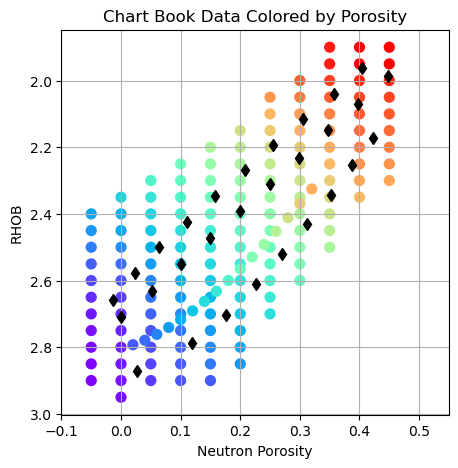

In [20]:
plt.figure(figsize=(5,5))    
#plt.scatter(CNL_chart, RHOB_chart, c=Porosity_chart,cmap="RdYlGn",)
#plt.scatter(CNL_chart, RHOB_chart, s=50, c=Porosity_chart)
#plt.scatter(CNL_chart, RHOB_chart, c=Porosity_chart,cmap="RdYlGn")
plt.scatter(CNL_chart, RHOB_chart, s=50, c = Porosity_chart, cmap = "rainbow")
plt.plot(CNL_chart2, RHOB_chart2,'kd')
plt.xlim(-0.1, 0.55)
plt.gca().invert_yaxis()
plt.title("Chart Book Data Colored by Porosity")
plt.ylabel('RHOB')
plt.xlabel('Neutron Porosity')
plt.grid(True)
plt.show()

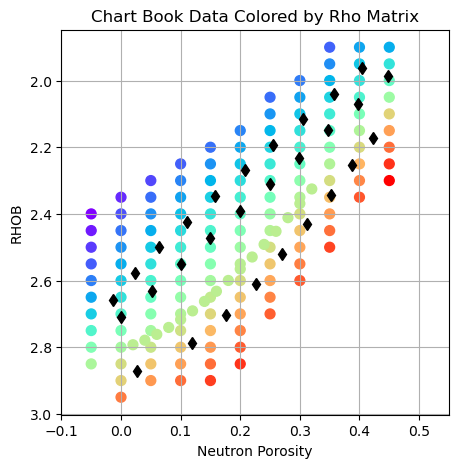

In [21]:
plt.figure(figsize=(5,5))    
#plt.scatter(CNL_chart, RHOB_chart, c=Porosity_chart,cmap="RdYlGn",)
#plt.scatter(CNL_chart, RHOB_chart, s=50, c=Porosity_chart)
#plt.scatter(CNL_chart, RHOB_chart, c=Porosity_chart,cmap="RdYlGn")
plt.scatter(CNL_chart, RHOB_chart, s=50, c = Rho_Matrix_chart, cmap = "rainbow")
plt.plot(CNL_chart2, RHOB_chart2,'kd')
plt.xlim(-0.1, 0.55)
plt.gca().invert_yaxis()
plt.title("Chart Book Data Colored by Rho Matrix")
plt.ylabel('RHOB')
plt.xlabel('Neutron Porosity')
plt.grid(True)
plt.show()

## 2a) kNN Used to estimate Cross Plot porosity and Rho Matrix from the appropriate chart:

In [22]:
"""
# =============================================================================
# # ===========================================================================
# # #--------------------------------------------------------------------------
# ##
# ##            This is the beginnin of KNN estimating ND xplt Porosity 
# ##
# # #--------------------------------------------------------------------------
# # ===========================================================================
# =============================================================================
"""  

#Fluid Density
FD = 1.1


deptharray = []
porarray   = []; #make list of 0 length
RHOMAA_array = []
Porosity_array = []
rhoarray = []


#log Data
for k in range(0,len(df_log) ,1):  

        cnl_norm  = (CNL[k]-(-0.05))/(0.6-(-0.05))
        rhob_norm = (RHOB[k]-1.9)/(3-1.9)
        


        dist_inv    = []
        dist_cnl    = []
        dist_rhob    = []
        inv_dist_array = []
        Por_weight = []
        Rhomatrix_weight =[]
        CNL_norm = []
        RHOB_norm = []

        dist_inv_total = 0
        Por_total     = 0



        #this is the chartbook_reference_data being used 
        for i in range(0,len(df_chart),1):
        
                CNL_norm.append((CNL_chart[i] - (-0.05)) / (0.6 - (-0.05)))
                RHOB_norm.append((RHOB_chart[i] - 1.9) / (3.0 - 1.9))
                
                #Euclidian Distance
                dist_cnl.append((abs(cnl_norm   - CNL_norm[i])))
                dist_rhob.append( abs(rhob_norm - RHOB_norm[i]))

                if math.sqrt(dist_cnl[i]**2 + dist_rhob[i]**2) > 0:
                    dist_inv.append( 1  /  math.sqrt( dist_cnl[i]**2 + dist_rhob[i]**2)  )
                else:
                    dist_inv.append( 1  /  math.sqrt( 0.0001 + dist_cnl[i]**2 + dist_rhob[i]**2)  )
        
                
                #calculalte weights
                Por_weight      .append(dist_inv[i] * Porosity_chart[i])
                Rhomatrix_weight.append(dist_inv[i] * Rho_Matrix_chart[i])
                
                
        
                inv_dist_array.append(dist_inv[i]);  # add items
        
        # =============================================================================
        ###                    KNN Array
        # # ===========================================================================
        # # #--------------------------------------------------------------------------
                distance_knn_array = [dist_inv, Por_weight, Rhomatrix_weight]
        #        distance_knn_array = [Permeability, Porosity, G1, PD1, BV1, G2, PD2, BV2]
        # # #--------------------------------------------------------------------------
        # # ===========================================================================
        # =============================================================================
        xnorm=np.array(CNL_norm)
        ynorm=np.array(RHOB_norm)
        
            
        #knn_array = np.transpose array
        knn_array = np.transpose(distance_knn_array)
        #print(knn_array)
        
        #Sort array from large to low by column 0 which is dist_inv 
        #xknn=np.array(knn_array)
        
        #matsor x[x[:,column].argsort()[::-1]] and -1 us reverse order
        mat_sort = knn_array[knn_array[:,0].argsort()[::-1]] #firt column reverse sort (-1)
        #mat_sort = x[x[:,1].argsort()[::-1]]
        #mat_sort = x[x[:,2].argsort()[::-1]]
        
         
        #------------------------------------------------------------------------------
        #    Number of nearest Neighbors
        #------------------------------------------------------------------------------
        n_neighbors = 3
        #------------------------------------------------------------------------------
        
        dist_inv_total_knn = 0
        por_total_knn      = 0
        rhomatrix_total_knn      = 0
        
        
        
        #kNN Estimates for first 3 rows
        #dist_inv_total = mat_sort[0][0] + mat_sort[1][0] + mat_sort[2][0]
        for i in range(0,n_neighbors,1):
            dist_inv_total_knn = dist_inv_total_knn + mat_sort[i][0]
            por_total_knn  = por_total_knn + mat_sort[i][1]
            rhomatrix_total_knn  = rhomatrix_total_knn + mat_sort[i][2]
        
        
        #back to k values and calculate estimations now
        por_est_knn  = por_total_knn  / dist_inv_total_knn
        rhomatrix_est_knn  = rhomatrix_total_knn  / dist_inv_total_knn
        

#------------------------------------------------------------------------------ 
#            Write Data to arrays
#------------------------------------------------------------------------------
        deptharray.append(Dep[k]);          # Taken from logs
        porarray.append(por_est_knn);       # Calculated Chartbook Porosity 
        rhoarray.append(rhomatrix_est_knn); # Calculated Chartbook Rhomatrix


print(len(porarray))

381


## Depth Plot of  PHIT and RHOMAA from kNN Estimations using Chartbook data as calibration:

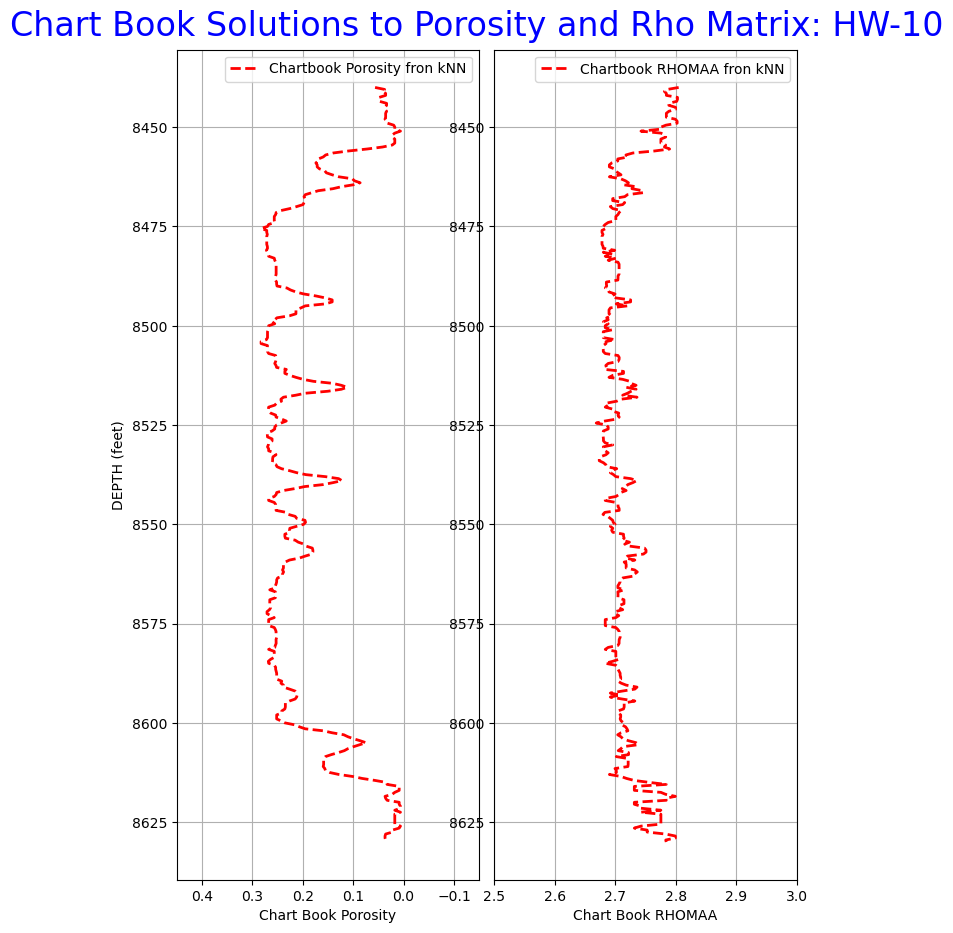

In [23]:
from matplotlib import gridspec

'''     
        deptharray.append(Dep[k]);          # Taken from logs
        porarray.append(por_est_knn);       # Calculated Chartbook Porosity 
        rhoarray.append(rhomatrix_est_knn); # Calculated Chartbook Rhomatrix
'''

y=np.array(deptharray)

fig = plt.figure(figsize=(8,10))
#fig.suptitle('Chart Book Solutions to Porosity and Rho Matrix',fontsize=28)
#fig.subplots_adjust(top=0.94,wspace=0.05, hspace =0.3)
wellname=las.well.well.value
fig.suptitle('Chart Book Solutions to Porosity and Rho Matrix: %s'%wellname, fontsize=24, color='blue')
fig.subplots_adjust(top=0.94, wspace=0.05, hspace =0.1)

gs = gridspec.GridSpec(1, 2)
ax1 = fig.add_subplot(gs[:,0])
ax2 = fig.add_subplot(gs[0,1])

# Porosity
ax1.plot(porarray, y,'--r',lw=2, label= 'Chartbook Porosity fron kNN')
ax1.invert_yaxis()
ax1.grid(True)
ax1.set_ylabel('DEPTH (feet)')
#ax11=ax1.twiny()
ax1.set_xlabel("Chart Book Porosity",color='black')
ax1.set_xlim(.45, -0.15)
ax1.legend()


# Rho Matrix
ax2.plot(rhoarray, y,'--r',lw=2, label= 'Chartbook RHOMAA fron kNN')                                                               
#ax2.plot(RHOMAA, y,'-b', lw=1, label= 'RHOMAA from MMin')
ax2.invert_yaxis()
ax2.grid(True)
ax2.set_xlabel("Chart Book RHOMAA",color='black')
ax2.set_xlim(2.5, 3)
ax2.legend()
#ax2.get_yaxis().set_visible(False)
#ax2=ax2.twiny()



# Plot Definitions for most plots:

In [24]:
def Optimization_plot():

    fig = plt.figure(figsize=(18,15))
    #fig.suptitle('Optimized Petrophysical Results',fontsize=32,color='blue')
    #fig.subplots_adjust(top=0.94,wspace=0.05, hspace =0.1)
    wellname=las.well.well.value
    fig.suptitle('Optimized Petrophysical Results from chatGPT: %s'%wellname, fontsize=32, color='blue')
    fig.subplots_adjust(top=0.94, wspace=0.05, hspace =0.1)

    gs = gridspec.GridSpec(1, 7)
    ax1 = fig.add_subplot(gs[:,0])
    ax2 = fig.add_subplot(gs[0,1])
    ax3 = fig.add_subplot(gs[0,2])
    ax4 = fig.add_subplot(gs[0,3])
    ax5 = fig.add_subplot(gs[0,4])
    ax6 = fig.add_subplot(gs[0,5])
    ax7 = fig.add_subplot(gs[0,6])

    y=np.array(deptharray)

    # Porosity Logs
    ax1.plot(porden, y,'-k',lw=2, label= 'Density Por')
    ax1.plot(CNL, y,'-g', lw=2, label= 'Neutron Por')
    ax1.plot(porarray, y,'-r',lw=3, label= 'kNN Chartbook Por')
    ax1.set_xlabel("Porosity Logs",color='black')
    ax1.set_ylabel('DEPTH (feet)')
    ax1.invert_yaxis()
    ax1.grid(True)
    ax1.set_xlim(.45, -0.15)
    ax1.fill_betweenx(y,CNL,porden, facecolor='#00ff00', hatch='--//')#, label= 'VOL_DOLO')
    ax1.legend()

    # Lithology
    quartz=np.array(VOL_QUARTZ)
    calcite=np.array(VOL_CALCITE)
    dolo=np.array(VOL_DOLO)
    illite=np.array(VOL_ILLITE)

    ax2.plot(illite, y,'-k',lw=2)
    ax2.plot(illite+quartz, y,'-k',lw=2)
    ax2.plot(illite+quartz+calcite, y,'-k',lw=1)
    ax2.plot(illite+quartz+calcite+dolo, y,'-k')
    ax2.set_xlim(0, 1)
    ax2.set_xlabel(('Optimized Lithology'), color='black')
    ax2.fill_betweenx(y,0,illite, facecolor='#d1d1d1' ,hatch='.-.-',label= 'VOL_ILLITE')
    ax2.fill_betweenx(y,illite,illite+quartz, facecolor='#ffff00' ,hatch='..',label= 'VOL_QUARTZ')
    ax2.fill_betweenx(y,illite+quartz,illite+quartz+calcite, facecolor='#00ffff' ,hatch='++',label= 'VOL_CALCITE')
    ax2.fill_betweenx(y,illite+quartz+calcite,illite+quartz+calcite+dolo, facecolor='#00ff00', hatch='--//', label= 'VOL_DOLO')
    ax2.fill_betweenx(y,illite+quartz+calcite+dolo,1,color='black', label= 'PHIT')
    ax2.legend()
    #ax2=ax[2].twiny()
    ax2.invert_yaxis()
    ax2.grid(True)
    #ax2.set_ylabel('DEPTH (feet)')
    ax2.get_yaxis().set_visible(False)


    # Modeled Neutron Log
    ax3.plot(CNL, y,'-g', lw=3, label= 'Neutron Por')
    ax3.plot(tnph_theoretical, y,'-k',lw=1, label= 'Pred Neutron Por')
    ax3.set_xlabel("Modeled Neutron Log",color='black')
    ax3.set_xlim(.45, -0.15)
    ax3.fill_betweenx(y,CNL,tnph_theoretical, color='yellow')#, label= 'VOL_DOLO')
    #ax3.get_yaxis().set_visible(False)
    ax3.legend()
    ax3.invert_yaxis()
    ax3.grid(True)
    #ax3.set_ylabel('DEPTH (feet)')
    #ax3.get_yaxis().set_visible(False)

    
    
    # Modeled Density Log
    ax4.plot(RHOB, y,'-r', lw=3, label= 'Bulk Density')
    ax4.plot(rhob_theoretical, y,'-k',lw=1, label= 'Pred Bulk Density')
    ax4.plot(rhoarray, y,'-g',lw=1, label= 'RHOMAA')
    ax4.set_xlabel("Modeled Bulk Density",color='black')
    ax4.set_xlim(2, 3)
    ax4.fill_betweenx(y,RHOB,rhob_theoretical, color='yellow')#, label= 'VOL_DOLO')
    ax4.fill_betweenx(y,error,0, color='red')#, label= 'VOL_DOLO')
    ax4.fill_betweenx(y,rhoarray,2.68, facecolor='#00ff00', hatch='--//', label= 'DOLO')
    #ax4.get_yaxis().set_visible(False)
    ax4.legend()
    ax4.invert_yaxis()
    ax4.grid(True)
    #ax4.set_ylabel('DEPTH (feet)')
    #ax4.get_yaxis().set_visible(False)

    
    
    # Error Theoretical vs. Actual normalized logs
    ax5.plot(error, y,'-r', lw=1, label= 'Error')
    ax5.set_xlabel("Calculated Error",color='black')
    ax5.set_xlim(0, 1.0)
    ax5.fill_betweenx(y,error,0.15, color='pink')#, label= 'VOL_DOLO')
    #ax4.get_yaxis().set_visible(False)
    ax5.legend()
    ax5.invert_yaxis()
    ax5.grid(True)
    #ax4.set_ylabel('DEPTH (feet)')
    #ax5.get_yaxis().set_visible(False)


    # Error Theoretical vs. Actual normalized logs
    ax6.plot(porarray, y,'-r', lw=1, label= 'PHIT')
    ax6.plot(bvw, y,'-k', lw=1, label= 'BVW')
    ax6.set_xlabel("Bulk Volume Calculations",color='black')
    ax6.set_xlim(0.5, 0.0)
    ax6.fill_betweenx(y,porarray,bvw, color='green')#, label= 'VOL_DOLO')
    ax6.fill_betweenx(y,bvw,0, color='cyan')#, label= 'VOL_DOLO')
    ax6.legend()
    ax6.invert_yaxis()
    ax6.grid(True)
    #ax6.get_yaxis().set_visible(False)

    
    
    # Modeled Density Log
    ax7.plot(gr, y,'-g', lw=3, label= 'GR')
    ax7.plot(gr_theoretical, y,'-k',lw=1, label= 'Pred GR')
    ax7.set_xlabel("Modeled GR",color='black')
    ax7.set_xlim(0, 100)
    ax7.fill_betweenx(y,gr,gr_theoretical, color='yellow')#, label= 'VOL_DOLO')
    #ax7.fill_betweenx(y,error,0, color='red')#, label= 'VOL_DOLO')
    #ax4.get_yaxis().set_visible(False)
    ax7.legend()
    ax7.invert_yaxis()
    ax7.grid(True)
    #ax4.set_ylabel('DEPTH (feet)')
    #ax7.get_yaxis().set_visible(False)

    
    
def Perm_plot():    
    fig = plt.figure(figsize=(18,15))
    #fig.suptitle('Optimized Petrophysical Results with kNN Permeability',fontsize=32,color='blue')
    #fig.subplots_adjust(top=0.94,wspace=0.05, hspace =0.1)
    wellname=las.well.well.value
    fig.suptitle('Optimized Petrophysical Results with kNN Permeability: %s'%wellname, fontsize=32, color='blue')
    fig.subplots_adjust(top=0.94, wspace=0.05, hspace =0.1)

    gs = gridspec.GridSpec(1, 7)
    ax1 = fig.add_subplot(gs[:,0])
    ax2 = fig.add_subplot(gs[0,1])
    ax3 = fig.add_subplot(gs[0,2])
    ax4 = fig.add_subplot(gs[0,3])
    ax5 = fig.add_subplot(gs[0,4])
    ax6 = fig.add_subplot(gs[0,5])
    ax7 = fig.add_subplot(gs[0,6])

    y=np.array(deptharray)

    # Porosity Logs
    ax1.plot(porden, y,'-k',lw=2, label= 'Density Por')
    ax1.plot(CNL, y,'-g', lw=2, label= 'Neutron Por')
    ax1.plot(porarray, y,'-r',lw=3, label= 'kNN Chartbook Por')
    ax1.set_xlabel("Porosity Logs",color='black')
    ax1.set_ylabel('DEPTH (feet)')
    ax1.invert_yaxis()
    ax1.grid(True)
    ax1.set_xlim(.45, -0.15)
    ax1.fill_betweenx(y,CNL,porden, facecolor='#00ff00', hatch='--//')#, label= 'VOL_DOLO')
    ax1.legend()

    # Lithology
    quartz=np.array(VOL_QUARTZ)
    calcite=np.array(VOL_CALCITE)
    dolo=np.array(VOL_DOLO)
    illite=np.array(VOL_ILLITE)

    ax2.plot(illite, y,'-k',lw=2)
    ax2.plot(illite+quartz, y,'-k',lw=2)
    ax2.plot(illite+quartz+calcite, y,'-k',lw=1)
    ax2.plot(illite+quartz+calcite+dolo, y,'-k')
    ax2.set_xlim(0, 1)
    ax2.set_xlabel(('Optimized Lithology'), color='black')
    ax2.fill_betweenx(y,0,illite, facecolor='#d1d1d1' ,hatch='.-.-',label= 'VOL_ILLITE')
    ax2.fill_betweenx(y,illite,illite+quartz, facecolor='#ffff00' ,hatch='..',label= 'VOL_QUARTZ')
    ax2.fill_betweenx(y,illite+quartz,illite+quartz+calcite, facecolor='#00ffff' ,hatch='++',label= 'VOL_CALCITE')
    ax2.fill_betweenx(y,illite+quartz+calcite,illite+quartz+calcite+dolo, facecolor='#00ff00', hatch='--//', label= 'VOL_DOLO')
    ax2.fill_betweenx(y,illite+quartz+calcite+dolo,1,color='black', label= 'PHIT')
    ax2.legend()
    #ax2=ax[2].twiny()
    ax2.invert_yaxis()
    ax2.grid(True)
    #ax2.set_ylabel('DEPTH (feet)')
    ax2.get_yaxis().set_visible(False)


    # Modeled Neutron Log
    ax3.plot(CNL, y,'-g', lw=3, label= 'Neutron Por')
    ax3.plot(tnph_theoretical, y,'-k',lw=1, label= 'Pred Neutron Por')
    ax3.set_xlabel("Modeled Neutron Log",color='black')
    ax3.set_xlim(.45, -0.15)
    ax3.fill_betweenx(y,CNL,tnph_theoretical, color='yellow')#, label= 'VOL_DOLO')
    #ax3.get_yaxis().set_visible(False)
    ax3.legend()
    ax3.invert_yaxis()
    ax3.grid(True)
    #ax3.set_ylabel('DEPTH (feet)')

    # Modeled Density Log
    ax4.plot(RHOB, y,'-r', lw=3, label= 'Bulk Density')
    ax4.plot(rhob_theoretical, y,'-k',lw=1, label= 'Pred Bulk Density')
    ax4.set_xlabel("Modeled Bulk Density",color='black')
    ax4.set_xlim(2, 3)
    ax4.fill_betweenx(y,RHOB,rhob_theoretical, color='yellow')#, label= 'VOL_DOLO')
    ax4.fill_betweenx(y,error,0, color='red')#, label= 'VOL_DOLO')
    #ax4.get_yaxis().set_visible(False)
    ax4.legend()
    ax4.invert_yaxis()
    ax4.grid(True)
    #ax4.set_ylabel('DEPTH (feet)')

    # Error Theoretical vs. Actual normalized logs
    ax5.plot(error, y,'-r', lw=1, label= 'Error')
    ax5.set_xlabel("Calculated Error",color='black')
    ax5.set_xlim(-1.0, 1.0)
    ax5.fill_betweenx(y,error,0.15, color='pink')#, label= 'VOL_DOLO')
    #ax4.get_yaxis().set_visible(False)
    ax5.legend()
    ax5.invert_yaxis()
    ax5.grid(True)
    #ax4.set_ylabel('DEPTH (feet)')


    # Error Theoretical vs. Actual normalized logs
    ax6.plot(porarray, y,'-r', lw=1, label= 'PHIT')
    ax6.plot(bvw, y,'-k', lw=1, label= 'BVW')
    ax6.set_xlabel("Bulk Volume Calculations",color='black')
    ax6.set_xlim(0.5, 0.0)
    ax6.fill_betweenx(y,porarray,bvw, color='green')#, label= 'VOL_DOLO')
    ax6.fill_betweenx(y,bvw,0, color='cyan')#, label= 'VOL_DOLO')
    ax6.legend()
    ax6.invert_yaxis()
    ax6.grid(True)

    # Permeability
    ax7.semilogx(perm, y,'-g', lw=1, label= 'Perm')
    ax7.semilogx(df_log['CORE_PERM'], y,'rd', lw=1, label= 'Core Perm')
    ax7.set_xlabel("kNN Permeability",color='green')
    ax7.set_xlim(0.2, 2000.0)
    ax7.legend()
    ax7.invert_yaxis()
    ax7.grid(True)    


  

def Thomeer_plot():    
    
    fig = plt.figure(figsize=(25,20))
    #fig.suptitle('kNN Permeability, Thomeer Parameters and PRT',fontsize=32, color='blue')
    #fig.subplots_adjust(top=0.94,wspace=0.05, hspace =0.1)
    wellname=las.well.well.value
    fig.suptitle('kNN Permeability, Thomeer Parameters and PRT: %s'%wellname, fontsize=32, color='blue')
    fig.subplots_adjust(top=0.94, wspace=0.05, hspace =0.1)

    gs = gridspec.GridSpec(1, 8)
    ax1 = fig.add_subplot(gs[:,0])
    ax2 = fig.add_subplot(gs[0,1])
    ax3 = fig.add_subplot(gs[0,2])
    ax4 = fig.add_subplot(gs[0,3])
    ax5 = fig.add_subplot(gs[0,4])
    ax6 = fig.add_subplot(gs[0,5])
    ax7 = fig.add_subplot(gs[0,6])
    ax8 = fig.add_subplot(gs[0,7])

    y=np.array(deptharray)
    
    # Porosity Logs
    ax1.plot(porden, y,'-k',lw=2, label= 'Density Por')
    ax1.plot(CNL, y,'-g', lw=2, label= 'Neutron Por')
    ax1.plot(porarray, y,'-r',lw=3, label= 'kNN Chartbook Por')
    ax1.set_xlabel("Porosity Logs",color='black')
    ax1.set_ylabel('DEPTH (feet)')
    ax1.invert_yaxis()
    ax1.grid(True)
    ax1.set_xlim(.45, -0.15)
    ax1.fill_betweenx(y,CNL,porden, facecolor='#00ff00', hatch='--//')#, label= 'VOL_DOLO')
    ax1.legend()

    # Lithology
    quartz=np.array(VOL_QUARTZ)
    calcite=np.array(VOL_CALCITE)
    dolo=np.array(VOL_DOLO)
    illite=np.array(VOL_ILLITE)

    ax2.plot(illite, y,'-k',lw=2)
    ax2.plot(illite+quartz, y,'-k',lw=2)
    ax2.plot(illite+quartz+calcite, y,'-k',lw=1)
    ax2.plot(illite+quartz+calcite+dolo, y,'-k')
    ax2.set_xlim(0, 1)
    ax2.set_xlabel(('Optimized Lithology'), color='black')
    ax2.fill_betweenx(y,0,illite, facecolor='#d1d1d1' ,hatch='.-.-',label= 'VOL_ILLITE')
    ax2.fill_betweenx(y,illite,illite+quartz, facecolor='#ffff00' ,hatch='..',label= 'VOL_QUARTZ')
    ax2.fill_betweenx(y,illite+quartz,illite+quartz+calcite, facecolor='#00ffff' ,hatch='++',label= 'VOL_CALCITE')
    ax2.fill_betweenx(y,illite+quartz+calcite,illite+quartz+calcite+dolo, facecolor='#00ff00', hatch='--//', label= 'VOL_DOLO')
    ax2.fill_betweenx(y,illite+quartz+calcite+dolo,1,color='black', label= 'PHIT')
    ax2.legend()
    #ax2=ax[2].twiny()
    ax2.invert_yaxis()
    ax2.grid(True)
    #ax2.set_ylabel('DEPTH (feet)')
    ax2.get_yaxis().set_visible(False)

    # Thomeer BVocc 
    BVocc1=np.array(bv1_est_knn)
    BVocc2=np.array(bv2_est_knn)

    # BVocc Depth Track
    ax3.plot(BVocc2, y,'-k', lw=1, label= 'BVocc 2')
    ax3.plot(BVocc2+BVocc1,y,'-b',lw=1, label= 'BVocc 1')
    #ax3.plot(BVocc2+BVocc1,y,'-b',lw=1, label= 'BVocc 1')

    ax3.set_xlabel("Thomeer BVocc",color='black')
    ax3.set_xlim(50., 0.0)
    ax3.fill_betweenx(y,BVocc2,BVocc1+BVocc2, color='cyan')#, label= 'VOL_DOLO')
    ax3.fill_betweenx(y,0,bv2_est_knn, color='orange')#, label= 'VOL_DOLO')
    #ax3.get_yaxis().set_visible(False)
    ax3.legend()
    ax3.invert_yaxis()
    ax3.grid(True)

    # Thomeer Pd
    Pd1=np.array(pd1_est_knn)
    Pd2=np.array(pd2_est_knn)

    # Pd Track
    ax4.semilogx(Pd1, y,'-b', lw=1, label= 'Pd1')
    ax4.semilogx(Pd2, y,'-',color='orange', lw=1, label= 'Pd2')
    ax4.set_xlabel("Thomeer Pd",color='black')
    ax4.set_xlim(1, 10000)
    ax4.legend()
    ax4.invert_yaxis()
    ax4.grid(True)
    #ax4.set_ylabel('DEPTH (feet)')

    # Thomeer G
    G1=np.array(g1_est_knn)
    G2=np.array(g2_est_knn)

    # Thomeer G
    ax5.plot(G1, y,'-b', lw=1, label= 'G1')
    ax5.plot(G2, y,'-k', lw=1, label= 'G2')
    ax5.set_xlabel("Thomeer G",color='black')
    ax5.set_xlim(0, 2.0)
    ax5.legend()
    ax5.invert_yaxis()
    ax5.grid(True)

    # Error Theoretical vs. Actual normalized logs

    ax6.plot(porarray, y,'-r', lw=1, label= 'PHIT')
    ax6.plot(bvw, y,'-k', lw=1, label= 'BVW')
    ax6.set_xlabel("Bulk Volume Calculations",color='black')
    ax6.set_xlim(0.5, 0.0)
    ax6.fill_betweenx(y,porarray,bvw, color='green')#, label= 'VOL_DOLO')
    ax6.fill_betweenx(y,bvw,0, color='cyan')#, label= 'VOL_DOLO')
    ax6.legend()
    ax6.invert_yaxis()
    ax6.grid(True)

    # Permeability
    ax7.semilogx(perm, y,'-g', lw=2, label= 'Perm')
    ax7.semilogx(mode, y,'-r', lw=2, label= 'Mode of PTD')
    ax7.set_xlabel("kNN Permeability",color='black')
    ax7.set_xlim(0.1, 1000.0)
    ax7.legend()
    ax7.invert_yaxis()
    ax7.grid(True)

    # Rock Index or PRT
    ax8.plot(rock_index_knn, y,'-k', lw=1, label= 'PRT')
    ax8.set_xlabel("Petrophysical Rock Types",color='black')
    ax8.set_xlim(0., 7.0)
    ax8.fill_betweenx(y,rock_index_knn,7, color='cyan')
    ax8.legend()
    ax8.invert_yaxis()
    ax8.grid(True)

    ## Setting Up Shading for PRT
    left_col_value = 2
    right_col_value = 7
    span = abs(left_col_value - right_col_value)
    cmap = plt.get_cmap('rainbow')
    #cmap = plt.get_cmap('cool')

    color_index = np.arange(left_col_value, right_col_value, span / 6)
    #loop through each value in the color_index
    for index in sorted(color_index):
        index_value = (index - left_col_value)/span
        color = cmap(index_value) #obtain color for color index value
        ax8.fill_betweenx(y, rock_index_knn , right_col_value, where = rock_index_knn >= index,  color = color)

        
        
 
def BVO_plot():
    fig = plt.figure(figsize=(18,15))
    #fig.suptitle('Thomeer Parameters and Thomeer BVO from Pc',fontsize=32,color='blue')
    #fig.subplots_adjust(top=0.94,wspace=0.05, hspace =0.1)
    wellname=las.well.well.value
    fig.suptitle('Thomeer Parameters and Thomeer BVO from Pc: %s'%wellname, fontsize=32, color='blue')#,y=0.9)
    fig.subplots_adjust(top=0.94,wspace=0.05, hspace =0.1)


    gs = gridspec.GridSpec(1, 7)
    ax1 = fig.add_subplot(gs[:,0])
    ax2 = fig.add_subplot(gs[0,1])
    ax3 = fig.add_subplot(gs[0,2])
    ax4 = fig.add_subplot(gs[0,3])
    ax5 = fig.add_subplot(gs[0,4])
    ax6 = fig.add_subplot(gs[0,5])
    ax7 = fig.add_subplot(gs[0,6])

    y=np.array(deptharray)

    # Porosity Logs
    ax1.plot(porden, y,'-k',lw=2, label= 'Density Por')
    ax1.plot(CNL, y,'-g', lw=2, label= 'Neutron Por')
    ax1.plot(porarray, y,'-r',lw=3, label= 'kNN Chartbook Por')
    ax1.set_xlabel("Porosity Logs",color='black')
    ax1.set_ylabel('DEPTH (feet)')
    ax1.invert_yaxis()
    ax1.grid(True)
    ax1.set_xlim(.45, -0.15)
    ax1.fill_betweenx(y,CNL,porden, facecolor='#00ff00', hatch='--//')#, label= 'VOL_DOLO')
    ax1.legend()

    # Lithology
    quartz=np.array(VOL_QUARTZ)
    calcite=np.array(VOL_CALCITE)
    dolo=np.array(VOL_DOLO)
    illite=np.array(VOL_ILLITE)

    ax2.plot(illite, y,'-k',lw=2)
    ax2.plot(illite+quartz, y,'-k',lw=2)
    ax2.plot(illite+quartz+calcite, y,'-k',lw=1)
    ax2.plot(illite+quartz+calcite+dolo, y,'-k')
    ax2.set_xlim(0, 1)
    ax2.set_xlabel(('Optimized Lithology'), color='black')
    ax2.fill_betweenx(y,0,illite, facecolor='#d1d1d1' ,hatch='.-.-',label= 'VOL_ILLITE')
    ax2.fill_betweenx(y,illite,illite+quartz, facecolor='#ffff00' ,hatch='..',label= 'VOL_QUARTZ')
    ax2.fill_betweenx(y,illite+quartz,illite+quartz+calcite, facecolor='#00ffff' ,hatch='++',label= 'VOL_CALCITE')
    ax2.fill_betweenx(y,illite+quartz+calcite,illite+quartz+calcite+dolo, facecolor='#00ff00', hatch='--//', label= 'VOL_DOLO')
    ax2.fill_betweenx(y,illite+quartz+calcite+dolo,1,color='black', label= 'PHIT')
    ax2.legend()
    #ax2=ax[2].twiny()
    ax2.invert_yaxis()
    ax2.grid(True)
    #ax2.set_ylabel('DEPTH (feet)')
    ax2.get_yaxis().set_visible(False)

    # Thomeer BVocc 
    BVocc1=np.array(bv1_est_knn)
    BVocc2=np.array(bv2_est_knn)

    # BVocc Depth Track
    ax3.plot(BVocc2, y,'-k', lw=1, label= 'BVocc 2')
    ax3.plot(BVocc1+BVocc2,y,'-b',lw=1, label= 'BVocc 1')
    ax3.set_xlabel("Thomeer BVocc",color='black')
    ax3.set_xlim(50., 0.0)
    ax3.fill_betweenx(y,BVocc2,BVocc1+BVocc2, color='cyan')#, label= 'VOL_DOLO')
    ax3.fill_betweenx(y,0,BVocc2, color='orange')#, label= 'VOL_DOLO')
    #ax3.get_yaxis().set_visible(False)
    ax3.legend()
    ax3.invert_yaxis()
    ax3.grid(True)

    # Thomeer Pd
    Pd1=np.array(pd1_est_knn)
    Pd2=np.array(pd2_est_knn)

    # Pd Track
    ax4.semilogx(Pd1, y,'-b', lw=1, label= 'Pd1')
    ax4.semilogx(Pd2, y,'-',color='orange', lw=1, label= 'Pd2')
    ax4.set_xlabel("Thomeer Pd",color='black')
    ax4.set_xlim(1, 10000)
    ax4.legend()
    ax4.invert_yaxis()
    ax4.grid(True)
    #ax4.set_ylabel('DEPTH (feet)')


    # Thomeer G
    G1=np.array(g1_est_knn)
    G2=np.array(g2_est_knn)

    # Thomeer G
    ax5.plot(G1, y,'-b', lw=1, label= 'G1')
    ax5.plot(G2, y,'-',color='orange', lw=1, label= 'G2')
    ax5.set_xlabel("Thomeer G",color='black')
    ax5.set_xlim(0, 2.0)
    ax5.legend()
    ax5.invert_yaxis()
    ax5.grid(True)

    # Error Theoretical vs. Actual normalized logs
    ax6.plot(porarray, y,'-r', lw=1, label= 'PHIT')
    ax6.plot(bvw, y,'-k', lw=1, label= 'BVW')
    ax6.set_xlabel("Bulk Volume Calculations",color='black')
    ax6.set_xlim(0.5, 0.0)
    ax6.fill_betweenx(y,porarray,bvw, color='green')#, label= 'VOL_DOLO')
    ax6.fill_betweenx(y,bvw,0, color='cyan')#, label= 'VOL_DOLO')
    ax6.legend()
    ax6.invert_yaxis()
    ax6.grid(True)

    # Thomeer BVO
    ax7.plot(bvo, y,'-', color='olive', lw=3, label= 'BVO logs')
    ax7.plot(bvo_thomeer, y,'-', color='magenta', lw=3, label= 'BVO Thomeer Pc')
    ax7.set_xlabel("Thomeer BVO",color='black')
    ax7.set_xlim(0., 0.3)
    ax7.legend()
    ax7.invert_yaxis()
    ax7.grid(True)

    
    
def Plot_sw( m, n, rw):
 
    bvw = []
    bvo=[]
    swt = []


    #log Data
    for k in range(0,len(df_log) ,1):  

        TNPH    = CNL[k]
        RHOB2   = RHOB[k]
        GR      = gr[k]
        ILD     = ild[k]
        PHIT    = porarray[k]
        RHOMAA2 = rhoarray[k]

        PORDEN  = (RHOMAA2 - RHOB2)/(RHOMAA2 - FD)

        # =================================================================================
        #       Saturation Calculations
        # =================================================================================
        BVW = PHIT * ( (1/PHIT**m) * (rw/ILD) )**(1/n)

        if BVW > PHIT:
            BVW=PHIT
        else:
            BVW=BVW

        Swt = BVW/PHIT
        BVO = (PHIT*(1-Swt))
        bvo.append(BVO)
        swt.append(Swt)    
        bvw.append(BVW)    
 
    
    ######fig, axs = plt.subplot_mosaic([['left', 'right'],['middle','middle'],['bottom', 'bottom']])
    #fig, axs = plt.subplot_mosaic([['left', 'middle','right'],['bottom', 'bottom','bottom']])
    fig, axs = plt.subplot_mosaic([['left', 'middle','right']])

                              #constrained_layout=True)

    #fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(7, 7))
    fig.suptitle('Saturations from Logs',color='blue' , fontsize=16)
    fig.subplots_adjust(top=0.90,wspace=0.2, hspace =.15)
    fig.set_figheight(6)
    fig.set_figwidth(15)
   

    y=np.array(deptharray)

    # Depth Plot 
    axs['left'].plot(porarray, y,'-r', lw=1)#, label= 'PHIT')
    axs['left'].plot(bvw, y,'-k', lw=1)#, label= 'BVW')
    axs['left'].set_title("Bulk Volume Plot",color='blue')    
    axs['left'].set_xlabel("BVO/BVW",color='blue')
    axs['left'].set_ylabel("Depth",color='blue')
    axs['left'].set_xlim(0.5, 0.0)
    axs['left'].set_ylim(max(y), min(y))
    axs['left'].fill_betweenx(y,porarray,bvw, color='green', label= 'BVO')
    axs['left'].fill_betweenx(y,bvw,0, color='cyan', label= 'BVW')
    axs['left'].legend()
    axs['left'].grid()

    # Depth Plot 
    #plt.axhline(y=0.5, color='r', linestyle='-')
    axs['right'].axvline(x=m,  color='r', linestyle='-', label= 'm')
    axs['right'].axvline(x=n,  color='b', linestyle='-.', label= 'n')
    axs['right'].set_title("m&n",color='blue')    
    axs['right'].set_xlabel("Electrical Properties",color='blue')
    #axs['right'].set_ylabel("Depth",color='blue')
    axs['right'].set_xlim(1, 3)
    axs['right'].set_ylim(max(y), min(y))
    #axs['right'].fill_betweenx(y,porarray,bvw, color='green', label= 'BVO')
    #axs['right'].fill_betweenx(y,bvw,0, color='cyan', label= 'BVW')
    axs['right'].legend()
    axs['right'].grid()
    #axs[0, 1].remove()  # don't display empty ax
    
    #axs['left'].sharey(axs['right'])
    #axs['right'].sharey(axs['left'])
    
    # Pickett Plot
    axs['middle'].loglog(ild,porarray, 'ro')
    axs['middle'].set_xlim(0.01,1000)
    axs['middle'].set_ylim(0.01,1)
    axs['middle'].set_title('Pickett Plot', color = 'blue')
    axs['middle'].set_ylabel('PHIT [v/v]', color = 'blue')
    axs['middle'].set_xlabel('ILD [ohmm]', color = 'blue')
    axs['middle'].grid()
    ######axs['middle'].xaxis.set_major_formatter(ticker.FormatStrFormatter("%.2f"))
    ######axs['middle'].yaxis.set_major_formatter(ticker.FormatStrFormatter("%.2f"))   
    
    #calculate the saturation lines
    sw_plot=(1.0,0.8,0.6,0.4,0.2)
    phit_plot=(0.01,1)
    rt_plot=np.zeros((len(sw_plot),len(phit_plot)))

    for i in range (0,len(sw_plot)):
        for j in range (0,len(phit_plot)):
            rt_result=((rw)/(sw_plot[i]**n)*(1/(phit_plot[j]**m)))
            rt_plot[i,j]=rt_result      
    for i in range(0,len(sw_plot)):
        axs['middle'].plot(rt_plot[i],phit_plot, linewidth=2, label='SW '+str(int(sw_plot[i]*100))+'%')
        axs['middle'].legend (loc='best')
    axs['middle'].grid(True, which='both',ls='-' ,color='gray')

    
    phit_buck_plot = (0.05,0.07,0.1,0.15,0.2,0.25,0.3,0.35)
    sw_buck_plot   = (1,0.75,0.5,0.33,0.25,0.2,0.16,0.14)
    
    
def Plot_gd(GD_dolo,GR_dolo,GR_calc,tools,lith_option,illite_option):


    '''
    # =============================================================================
    # # ===========================================================================
    # # #--------------------------------------------------------------------------
    # ##
    # ##            Start Code for Scipy Optimization using minimization
    # ##
    # # #--------------------------------------------------------------------------
    # # ===========================================================================
    # =============================================================================
    '''
    VOL_QUARTZ = []
    VOL_CALCITE = []
    VOL_DOLO = []
    porden =[]
    VOL_ILLITE = []
    tnph = []
    #bvw = []
    #bvo=[]
    #swt = []

    rhob_theoretical = []
    tnph_theoretical = []
    gr_theoretical   = []
    error = []


    '''
    deptharray.append(Dep[k]);          # Taken from logs
    RHOMAA_array.append(RHOMAA[k]);     # Taken from Log data
    Porosity_array.append(Porosity[k]); # Taken from log data
    porarray.append(por_est_knn);       # Calculated from logs 
    rhoarray.append(rhomatrix_est_knn); # Calculated from logs
    '''


    if tools == 'Neutron_Density':    
        #log Data
        for k in range(0,len(df_log) ,1):  

            TNPH    = CNL[k]
            RHOB2   = RHOB[k]
            GR      = gr[k]
            ILD     = ild[k]
            PHIT    = porarray[k]
            RHOMAA2 = rhoarray[k]

            PORDEN  = (RHOMAA2 - RHOB2)/(RHOMAA2 - FD)

            # =================================================================================
            #       Illite Option Calculations
            # =================================================================================
            if illite_option == 'yes':
                vol_illite = -0.0424035 + 0.00562239*GR
                illite     = vol_illite/(1-PHIT)
            else:
                vol_illite = 0
                illite     = 0


            # =============================================================================
            # # ===========================================================================
            # # #--------------------------------------------------------------------------
            # ##
            # ##         Scipy Optimization for Lithology of Calcite and Dolomite
            # ##
            # # #--------------------------------------------------------------------------
            # # ===========================================================================
            # =============================================================================
            if lith_option == 'Calcite_Dolomite' :   


                # Function to minimize
                def optimization_function(xy):
                    RHOB_theoretical = (2.52*illite  + 2.71*xy[0] + GD_dolo*xy[1])*(1-PHIT) + FD*PHIT
                    TNPH_theoretical = (0.247*illite + 0*xy[0] + 0.05375*xy[1])*(1-PHIT) + 1.0*PHIT             
                    return (RHOB2 - RHOB_theoretical)**2 + (TNPH - TNPH_theoretical)**2

                # constraints

                # bounds
                #bnds = [ (0.05, 1), (0, 1 - 0.05 - 0.05)]
                # Bounds x is 0 to 1 and y is 0 to 1
                bnds = [(0.0, 1.0),(0.0, 1.0)]

                            # constraints
                cons = [
                    {'type': 'eq',   'fun': lambda x: illite + x[0] + x[1] - 1}, # sum of xy[0], xy[1] must be equal to 1
                    {'type': 'ineq', 'fun': lambda x: x[0] - 0.001}, # xy[0] must be greater than or equal to 0.01
                    {'type': 'ineq', 'fun': lambda x: x[1] - 0.001} # xy[1] must be greater than or equal to 0.01
                    ]


                result = minimize(optimization_function, x0=[0, 0], constraints = cons, bounds=bnds, method='SLSQP', options={'maxiter': 1000})
                xy_optimal = result.x

                x = xy_optimal[0]
                y = xy_optimal[1]


                VOL_ILLITE.append(vol_illite)             
                VOL_QUARTZ.append(0)
                VOL_CALCITE.append(x*(1-PHIT))
                VOL_DOLO.append(y*(1-PHIT))

                rhob_theoretical.append(( 2.52*illite  + 2.71*x   +   GD_dolo   *y)*(1-PHIT) + FD*PHIT)
                tnph_theoretical.append((0.247*illite  +  0*x     +   0.05375*y)*(1-PHIT) + 1.0*PHIT)
                gr_theoretical.append((160*illite +  11*x     +   8*y)        *(1-PHIT) + 0.0*PHIT)

                #print('Theoretical RHOB =' , round(rhob_theoretical, 3)  , ', RHOB =',RHOB2)                     


            # =============================================================================
            # # ===========================================================================
            # # #--------------------------------------------------------------------------
            # ##
            # ##       Scipy Optimization for Lithology of Quartz, Cakcite and Dolomite
            # ##
            # # #--------------------------------------------------------------------------
            # # ===========================================================================
            # =============================================================================    
            elif lith_option == 'Quartz_Calcite_Dolomite' :   
                if RHOMAA2 > 2.0:


                    def optimization_function(xy):
                        RHOB_theoretical = (2.52*illite + 2.65*xy[0] + 2.71*xy[1] + GD_dolo*xy[2])*(1-PHIT) + FD*PHIT
                        TNPH_theoretical = (0.247*illite -0.05*xy[0] + 0*xy[1] + 0.05375*xy[2])*(1-PHIT) + 1.0*PHIT  
                        return (RHOB2 - RHOB_theoretical)**2 + (TNPH - TNPH_theoretical)**2

                    # constraints

                    # bounds
                    bnds = [(0, 1), (0, 1), (0, 1)]

                    # constraints
                    cons = [
                        {'type': 'eq', 'fun': lambda x: illite + x[0] + x[1] + x[2] - 1}, # sum of xy[0], xy[1], xy[2] must be equal to 1
                        {'type': 'ineq', 'fun': lambda x: x[0] - 0.001}, # xy[0] must be greater than or equal to 0.01
                        {'type': 'ineq', 'fun': lambda x: x[1] - 0.001}, # xy[1] must be greater than or equal to 0.01
                        {'type': 'ineq', 'fun': lambda x: x[2] - 0.001}  # xy[1] must be greater than or equal to 0.01 
                    ]


                    result = minimize(optimization_function, x0=[0, 0, 0], constraints=cons, bounds=bnds, method='SLSQP', options={'maxiter': 1000})

                    xy_optimal = result.x


                    x = xy_optimal[0]
                    y = xy_optimal[1]
                    z = xy_optimal[2]



                    VOL_ILLITE.append(vol_illite)
                    VOL_QUARTZ.append(x*(1-PHIT))
                    VOL_CALCITE.append(y*(1-PHIT))
                    VOL_DOLO.append(z*(1-PHIT))

                    rhob_theoretical.append((2.520*illite + 2.65*x + 2.71*y + GD_dolo   *z)*(1-PHIT) + FD*PHIT)
                    tnph_theoretical.append((0.247*illite - 0.05*x + 0.0*y  + 0.05373*z)*(1-PHIT) + 1.0*PHIT)
                    gr_theoretical.append((160*illite + 1*x +  11*y     +   8*z)        *(1-PHIT) + 0.0*PHIT)

                    #print('Theoretical RHOB =' , round(rhob_theoretical, 3)  , ', RHOB =',RHOB2)                     



                else:

                    VOL_ILLITE.append(vol_illite)
                    VOL_QUARTZ.append(1-PHIT)
                    VOL_CALCITE.append(0)
                    VOL_DOLO.append(0)

                    rhob_theoretical.append(0)
                    tnph_theoretical.append(0)
                    error.append(0)       


            porden.append(PORDEN)   
            tnph.append(TNPH)

            rhob_norm = (RHOB[k] - 1.9) / (3.0 - 1.9)
            rhob_norm_theo = (rhob_theoretical[k] - 1.9) / (3.0 - 1.9)
            tnph_norm = (CNL[k] - (-0.05)) / (0.6 - (-0.05))
            tnph_norm_theo = (tnph_theoretical[k] - (-0.05)) / (0.6 - (-0.05))     

            error.append(0.5*abs((rhob_norm-rhob_norm_theo)+(tnph_norm-tnph_norm_theo))/(PHIT))

    elif tools == 'Neutron_Density_GR': 

        for k in range(0,len(df_log) ,1):  

            TNPH    = CNL[k]
            RHOB2   = RHOB[k]
            GR      = gr[k]
            ILD     = ild[k]
            PHIT    = porarray[k]
            RHOMAA2 = rhoarray[k]

            PORDEN  = (RHOMAA2 - RHOB2)/(RHOMAA2 - FD)

            # =================================================================================
            #       Illite Option Calculations
            # =================================================================================
            if illite_option == 'yes':
                vol_illite = -0.0424035 + 0.00562239*GR
                illite     = vol_illite/(1-PHIT)
            else:
                vol_illite = 0
                illite     = 0


            # =============================================================================
            # # ===========================================================================
            # # #--------------------------------------------------------------------------
            # ##
            # ##         Scipy Optimization for Lithology of Calcite and Dolomite
            # ##
            # # #--------------------------------------------------------------------------
            # # ===========================================================================
            # =============================================================================
            if lith_option == 'Calcite_Dolomite' :   


                # Function to minimize
                def optimization_function(xy):
                    RHOB_theoretical = (2.52*illite  + 2.71*xy[0] + GD_dolo*xy[1])*(1-PHIT) + 1.2*PHIT
                    TNPH_theoretical = (0.247*illite + 0*xy[0] + 0.05375*xy[1])*(1-PHIT) + 1.0*PHIT    
                    GR_theoretical   = (160*illite + GR_calc*xy[0] + GR_dolo*xy[1])*(1-PHIT) + 0.0*PHIT
                    return (RHOB2 - RHOB_theoretical)**2 + (TNPH - TNPH_theoretical)**2 + (GR - GR_theoretical)**2

                # constraints

                # bounds
                #bnds = [ (0.05, 1), (0, 1 - 0.05 - 0.05)]
                # Bounds x is 0 to 1 and y is 0 to 1
                bnds = [(0.0, 1.0),(0.0, 1.0)]

                            # constraints
                cons = [
                    {'type': 'eq',   'fun': lambda x: illite + x[0] + x[1] - 1}, # sum of xy[0], xy[1] must be equal to 1
                    #{'type': 'eq',   'fun': lambda x: (illite + x[0] + x[1])*(1-PHIT) + PHIT - 1}, # sum of xy[0], xy[1] must be equal to 1 
                    {'type': 'ineq', 'fun': lambda x: x[0] - 0.001}, # xy[0] must be greater than or equal to 0.01
                    {'type': 'ineq', 'fun': lambda x: x[1] - 0.001} # xy[1] must be greater than or equal to 0.01
                    ]


                result = minimize(optimization_function, x0=[0, 0], constraints = cons, bounds=bnds, method='SLSQP', options={'maxiter': 1000})
                xy_optimal = result.x

                x = xy_optimal[0]
                y = xy_optimal[1]


                VOL_ILLITE.append(vol_illite)             
                VOL_QUARTZ.append(0)
                VOL_CALCITE.append(x*(1-PHIT))
                VOL_DOLO.append(y*(1-PHIT))

                rhob_theoretical.append(( 2.52*illite  + 2.71*x   +   2.85*y)*(1-PHIT) + FD*PHIT)
                tnph_theoretical.append((0.247*illite  +  0*x     +   0.05375*y)*(1-PHIT) +    PHIT)
                gr_theoretical.append((160*illite +  GR_calc*x     +   GR_dolo*y)        *(1-PHIT) + 0.0*PHIT)

                #print('Theoretical RHOB =' , round(rhob_theoretical, 3)  , ', RHOB =',RHOB2)                     


            # =============================================================================
            # # ===========================================================================
            # # #--------------------------------------------------------------------------
            # ##
            # ##       Scipy Optimization for Lithology of Quartz, Cakcite and Dolomite
            # ##
            # # #--------------------------------------------------------------------------
            # # ===========================================================================
            # =============================================================================    
            elif lith_option == 'Quartz_Calcite_Dolomite' :   
                if RHOMAA2 > 2.0:


                    def optimization_function(xy):
                        RHOB_theoretical = (2.52*illite + 2.65*xy[0] + 2.71*xy[1] + GD_dolo*xy[2])*(1-PHIT) + 1.2*PHIT
                        TNPH_theoretical = (0.247*illite -0.05*xy[0] + 0*xy[1] + 0.05375*xy[2])*(1-PHIT) + 1.0*PHIT 
                        GR_theoretical   = (160*illite + 1*xy[0] + GR_calc*xy[1] + GR_dolo*xy[2])*(1-PHIT) + 0.0*PHIT
                        return (RHOB2 - RHOB_theoretical)**2 + (TNPH - TNPH_theoretical)**2 + (GR - GR_theoretical)**2

                    # constraints

                    # bounds
                    bnds = [(0, 1), (0, 1), (0, 1)]

                    # constraints
                    cons = [
                        {'type': 'eq', 'fun': lambda x: illite + x[0] + x[1] + x[2] - 1}, # sum of xy[0], xy[1], xy[2] must be equal to 1
                        {'type': 'ineq', 'fun': lambda x: x[0] - 0.001}, # xy[0] must be greater than or equal to 0.01
                        {'type': 'ineq', 'fun': lambda x: x[1] - 0.001}, # xy[1] must be greater than or equal to 0.01
                        {'type': 'ineq', 'fun': lambda x: x[2] - 0.001}  # xy[1] must be greater than or equal to 0.01 
                    ]


                    result = minimize(optimization_function, x0=[0, 0, 0], constraints=cons, bounds=bnds, method='SLSQP', options={'maxiter': 1000})

                    xy_optimal = result.x


                    x = xy_optimal[0]
                    y = xy_optimal[1]
                    z = xy_optimal[2]



                    VOL_ILLITE.append(vol_illite)
                    VOL_QUARTZ.append(x*(1-PHIT))
                    VOL_CALCITE.append(y*(1-PHIT))
                    VOL_DOLO.append(z*(1-PHIT))

                    rhob_theoretical.append((2.520*illite + 2.65*x + 2.71*y + GD_dolo*z)*(1-PHIT) + 1.2*PHIT)
                    tnph_theoretical.append((0.247*illite - 0.05*x + 0.0*y  + 0.05373*z)*(1-PHIT) + 1.0*PHIT)
                    gr_theoretical.append((160*illite + 1*x +  GR_calc*y     +   GR_dolo*z)        *(1-PHIT) + 0.0*PHIT)
                    #print('Theoretical RHOB =' , round(rhob_theoretical, 3)  , ', RHOB =',RHOB2)                     


                else:

                    VOL_ILLITE.append(vol_illite)
                    VOL_QUARTZ.append(1-PHIT)
                    VOL_CALCITE.append(0)
                    VOL_DOLO.append(0)

                    rhob_theoretical.append(0)
                    tnph_theoretical.append(0)
                    error.append(0)       


            porden.append(PORDEN)   
            tnph.append(TNPH)

            rhob_norm = (RHOB[k] - 1.9)/(3.0 - 1.9)
            rhob_norm_theo = (rhob_theoretical[k] - 1.9)/(3.0 - 1.9)
            tnph_norm = ( CNL[k] - (-0.05))/(0.6 - (-0.05))
            tnph_norm_theo = (tnph_theoretical[k] - (-0.05))/(0.6 - (-0.05))    
            gr_norm = ( gr[k] -  0)/(150 - 0)
            gr_norm_theo = (gr_theoretical[k] - 0)/(150 - 0)    


            error.append(0.333*abs((rhob_norm-rhob_norm_theo)+(tnph_norm-tnph_norm_theo)+(gr_norm-gr_norm_theo))/(PHIT))


    '''
    # =============================================================================
    #      Display Optimization Petrophysics
    # ============================================================================='''
    #Optimization_plot()



    
    ######fig, axs = plt.subplot_mosaic([['left', 'right'],['middle','middle'],['bottom', 'bottom']])
    #fig, axs = plt.subplot_mosaic([['left', 'middle','right'],['bottom', 'bottom','bottom']])
    fig, axs = plt.subplot_mosaic([['farleft','left', 'right','farright'],['middlel','middlel','middle','middle']])

                              #constrained_layout=True)

    #fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(7, 7))
    fig.suptitle('Lithology from Logs',color='blue' , fontsize=16)
    fig.subplots_adjust(top=0.92,wspace=0.1, hspace =.25)
    fig.set_figheight(8)
    fig.set_figwidth(6)
   

    y=np.array(deptharray)


    axs['farleft'].plot(gr, y,'-g', lw=3, label= 'GR')
    #axs['farleft'].plot(gr_theoretical, y,'-k',lw=1, label= 'Pred GR')
    axs['farleft'].axvline(x=GR_calc,  color='b', linestyle='-', label= 'GR Calc')
    axs['farleft'].axvline(x=GR_dolo,  color='g', linestyle='-.', label= 'GR Dolo')
    axs['farleft'].set_title("GR",color='blue')
    axs['farleft'].set_xlabel("GR",color='blue')
    axs['farleft'].set_xlim(0, 80)
    axs['farleft'].fill_betweenx(y,gr,gr_theoretical, color='yellow')#, label= 'VOL_DOLO')
    axs['farleft'].legend()
    axs['farleft'].invert_yaxis()
    axs['farleft'].grid(True)
    
    
    
    # Depth Plot 
    axs['left'].plot(porarray, y,'-r', lw=1)#, label= 'PHIT')
    axs['left'].plot(bvw, y,'-k', lw=1)#, label= 'BVW')
    axs['left'].set_title("Bulk Volume Plot",color='blue')    
    axs['left'].set_xlabel("BVO/BVW",color='blue')
    axs['left'].set_ylabel("Depth",color='blue')
    axs['left'].set_xlim(0.5, 0.0)
    axs['left'].set_ylim(max(y), min(y))
    axs['left'].fill_betweenx(y,porarray,bvw, color='green', label= 'BVO')
    axs['left'].fill_betweenx(y,bvw,0, color='cyan', label= 'BVW')
    #axs['left'].legend()
    axs['left'].grid()
    axs['left'].get_yaxis().set_visible(False)

    
    
    # Lithology
    quartz=np.array(VOL_QUARTZ)
    calcite=np.array(VOL_CALCITE)
    dolo=np.array(VOL_DOLO)
    illite=np.array(VOL_ILLITE)
  
    axs['right'].plot(illite, y,'-k',lw=2)
    axs['right'].plot(illite+quartz, y,'-k',lw=2)
    axs['right'].plot(illite+quartz+calcite, y,'-k',lw=1)
    axs['right'].plot(illite+quartz+calcite+dolo, y,'-k')
    axs['right'].set_title("Lithology",color='blue')    
    axs['right'].set_xlim(0, 1)
    axs['right'].set_ylim(max(y), min(y))
    axs['right'].set_xlabel(('Lithology'), color='blue')
    axs['right'].fill_betweenx(y,0,illite, facecolor='#d1d1d1' ,hatch='.-.-',label= 'VOL_ILLITE')
    axs['right'].fill_betweenx(y,illite,illite+quartz, facecolor='#ffff00' ,hatch='..',label= 'VOL_QUARTZ')
    axs['right'].fill_betweenx(y,illite+quartz,illite+quartz+calcite, facecolor='#00ffff' ,hatch='++',label= 'VOL_CALCITE')
    axs['right'].fill_betweenx(y,illite+quartz+calcite,illite+quartz+calcite+dolo, facecolor='#00ff00', hatch='--//', label= 'VOL_DOLO')
    axs['right'].fill_betweenx(y,illite+quartz+calcite+dolo,1,color='black', label= 'PHIT')
    #axs['right'].legend()
    axs['right'].invert_yaxis()
    axs['right'].grid(True)
    axs['right'].get_yaxis().set_visible(False)

    
    # Error Theoretical vs. Actual normalized logs
    axs['farright'].plot(error, y,'-r', lw=1, label= 'Error')
    axs['farright'].set_xlabel("Calculated Error",color='black')
    axs['farright'].set_xlim(0, 1.0)
    #axs['farright'].fill_betweenx(y,error,0.15, color='pink')#, label= 'VOL_DOLO')
    axs['farright'].set_title("Error",color='blue')
    axs['farright'].set_xlabel("Error",color='blue')
    #axs['farright'].legend()
    axs['farright'].invert_yaxis()
    axs['farright'].grid(True)
    axs['farright'].get_yaxis().set_visible(False)

    
    
    axs['middlel'].scatter(CNL, RHOB, s=25, c = gr, cmap = "rainbow")
    axs['middlel'].plot(CNL_chart2, RHOB_chart2,'kd')
    axs['middlel'].set_xlim(-0.1, 0.55)
    axs['middlel'].set_ylim(2.9, 1.9)
    #axs['middle'].gca().invert_yaxis()
    axs['middlel'].set_title("Cross Plot Data Colored by GR", color='blue')
    axs['middlel'].set_ylabel('RHOB', color='blue')
    axs['middlel'].set_xlabel('Neutron Porosity', color = 'blue')
    axs['middlel'].grid(True)
    #axs['middle'].show()    

    
    # Pickett Plot
    axs['middle'].loglog(ild,porarray, 'ro')
    axs['middle'].set_xlim(0.01,1000)
    axs['middle'].set_ylim(0.01,1)
    axs['middle'].set_title('Pickett Plot', color = 'blue')
    axs['middle'].set_ylabel('PHIT [v/v]', color = 'blue')
    axs['middle'].set_xlabel('ILD [ohmm]', color = 'blue')
    axs['middle'].grid()
    ######axs['middle'].xaxis.set_major_formatter(ticker.FormatStrFormatter("%.2f"))
    ######axs['middle'].yaxis.set_major_formatter(ticker.FormatStrFormatter("%.2f"))   
    
    #calculate the saturation lines
    sw_plot=(1.0,0.8,0.6,0.4,0.2)
    phit_plot=(0.01,1)
    rt_plot=np.zeros((len(sw_plot),len(phit_plot)))

    for i in range (0,len(sw_plot)):
        for j in range (0,len(phit_plot)):
            rt_result=((rw)/(sw_plot[i]**n)*(1/(phit_plot[j]**m)))
            rt_plot[i,j]=rt_result      
    for i in range(0,len(sw_plot)):
        axs['middle'].plot(rt_plot[i],phit_plot, linewidth=2, label='SW '+str(int(sw_plot[i]*100))+'%')
        #axs['middle'].legend (loc='best')
    axs['middle'].grid(True, which='both',ls='-' ,color='gray')

    
    phit_buck_plot = (0.05,0.07,0.1,0.15,0.2,0.25,0.3,0.35)
    sw_buck_plot   = (1,0.75,0.5,0.33,0.25,0.2,0.16,0.14)        

# 3a) Interactive Optimizing Petrophysics solving for Lithology using Scipy Optimize: 

#### a) Set lith_option to be either Quartz-Calcite-Dolomite or Calcite-Dolomite
#### b) Illite Option: include Illite as Clay (illite_option = 'yes') or Clay-free (illite_option = 'no')
## Scipy Optimization for Lithology:

### Refined by using chatGPT:

I have TNPH, RHOB , PHIT, RHOMAA2 and illite as known values. 

I want to calculate 3 mineral weight percents that I want to solve for using optimization. 

A theortetical RHOB can be calculated from the 3 mineral weight percents that we convert to volume percent by multiplying times (1-PHIT)

1) TNPH_theoretical = (0.247illite + 0*xy[0] + 0.05375*xy[1])*(1-PHIT) + PHIT

where we want TNPH = TNPH_Theoretical

2) RHOB_Theoretical = (2.52*illite + 2.65*xy[0] + 2.71*xy[1] + 2.847*xy[2])*(1-PHIT) + 1.19*PHIT) - RHOB

and RHOB = THOB_Theoretical

## This **Interactive Lithology Optimization** uses **Neutron-Density** or **Neutron-Density-GR** for the SciPy optimization where we used chatGPT to refine this section of the code:

In [25]:
# =================================================================================
#       Archie Saturation Constants
# =================================================================================
rw = 0.012 # Rw from Pickett Plot
m  = 2.1
n  = 2.1
#a  = 1.0
# =================================================================================



bvw = []
bvo=[]
swt = []


#log Data
for k in range(0,len(df_log) ,1):  

    TNPH    = CNL[k]
    RHOB2   = RHOB[k]
    GR      = gr[k]
    ILD     = ild[k]
    PHIT    = porarray[k]
    RHOMAA2 = rhoarray[k]

    PORDEN  = (RHOMAA2 - RHOB2)/(RHOMAA2 - FD)

    # =================================================================================
    #       Saturation Calculations
    # =================================================================================
    BVW = PHIT * ( (1/PHIT**m) * (rw/ILD) )**(1/n)

    if BVW > PHIT:
        BVW=PHIT
    else:
        BVW=BVW

    Swt = BVW/PHIT
    BVO = (PHIT*(1-Swt))
    bvo.append(BVO)
    swt.append(Swt)    
    bvw.append(BVW)    



# =================================================================================
#       Matrix Density Values
# =================================================================================
#GD_dolo = 2.85 # Rw from Pickett Plot
# =================================================================================



#dolo_slider  = widgets.FloatSlider(min=2.8 , max=2.9, value=2.85, step=0.01, description='Dolo Density')
dologd_slider  = widgets.FloatSlider(min=2.8 , max=2.9, value=2.85, step=0.01, description='Dolo GD')
dologr_slider  = widgets.FloatSlider(min=0 , max=30., value=8, step=1.0, description='Dolo GR')
calcgr_slider  = widgets.FloatSlider(min=0 , max=30., value=11, step=1.0, description='Calc GR')


rdbuttons1 = widgets.RadioButtons(
    options = ['Neutron_Density','Neutron_Density_GR'],
    value='Neutron_Density_GR',
    layout={'widdt':'max-content'},
    description = 'Logging Tools to use in Lithology Optimization:',
    disabled=False
)

rdbuttons2 = widgets.RadioButtons(
    options = ['Calcite_Dolomite','Quartz_Calcite_Dolomite'],
    value='Calcite_Dolomite',
    layout={'widdt':'max-content'},
    description = 'Lithology Options:',
    disabled=False
)

rdbuttons3 = widgets.RadioButtons(
    options = ['yes','no'],
    value='yes',
    layout={'widdt':'max-content'},
    description = 'Illite Option (yes/no):',
    disabled=False
)





widgets.interact(Plot_gd, GD_dolo = dologd_slider, GR_dolo = dologr_slider, GR_calc = calcgr_slider, tools=rdbuttons1,lith_option = rdbuttons2,illite_option = rdbuttons3)


interactive(children=(FloatSlider(value=2.85, description='Dolo GD', max=2.9, min=2.8, step=0.01), FloatSlider…

<function __main__.Plot_gd(GD_dolo, GR_dolo, GR_calc, tools, lith_option, illite_option)>

# 3b) Saturation Calculations - interactive Pickett Plot with m&n and Rw sliders:

## The 2nd START POINT can be found below to finish the analysis of this well after refining the Lithology calculations.

In [26]:
m_slider  = widgets.FloatSlider(min=1,max=3,step=0.01,value=2.0,description='m')
n_slider  = widgets.FloatSlider(min=1,max=3,step=0.01,value=1.9,description='n')
rw_slider = widgets.FloatLogSlider(min=-2,max=0,base=10, step=0.01, value=0.01,description='rw')

widgets.interact(Plot_sw, m = m_slider, n = n_slider, rw = rw_slider)
#This code will create two sliders for frequency and amplitude, and a plot that updates according to the slider values.


interactive(children=(FloatSlider(value=2.0, description='m', max=3.0, min=1.0, step=0.01), FloatSlider(value=…

<function __main__.Plot_sw(m, n, rw)>

## Run cell below to review and set final parameters and options before completing the analysis:

In [59]:
print('Well Data being used with elev_meas_ref:', text.value)
print()
print('Neutron-Density Chart =', chart)
print()
print('Electrical Properties: m =',round(m_slider.value,2), ', n =',round(n_slider.value,2), ', Rw =',round(rw_slider.value,3) )
print()
tools=rdbuttons1.value
print('Log curves to use to Optimize on lithology =', rdbuttons1.value)
print()
lith_option = rdbuttons2.value
print('lith_option =', rdbuttons2.value)
print()
illite_option = rdbuttons3.value
print('illite_option =', rdbuttons3.value)
print()
GD_dolo = dologd_slider.value
print('Matix Density of Dolomite =', round(dologd_slider.value,2),', 2.84 to 2.87?')
print()
GR_dolo = dologr_slider.value
print('GR of Dolomite =', round(dologr_slider.value,2), ', is 8 in MultiMin')
print()
GR_calc = calcgr_slider.value
print('GR of Calcite =', round(calcgr_slider.value,2), ', is 11 in MultiMin')

m = m_slider.value 
n = n_slider.value
rw = rw_slider.value

bvw = []
bvo=[]
swt = []


#log Data
for k in range(0,len(df_log) ,1):  

    TNPH    = CNL[k]
    RHOB2   = RHOB[k]
    GR      = gr[k]
    ILD     = ild[k]
    PHIT    = porarray[k]
    RHOMAA2 = rhoarray[k]

    PORDEN  = (RHOMAA2 - RHOB2)/(RHOMAA2 - FD)

    # =================================================================================
    #       Saturation Calculations
    # =================================================================================
    BVW = PHIT * ( (1/PHIT**m) * (rw/ILD) )**(1/n)

    if BVW > PHIT:
        BVW=PHIT
    else:
        BVW=BVW

    Swt = BVW/PHIT
    BVO = (PHIT*(1-Swt))
    bvo.append(BVO)
    swt.append(Swt)    
    bvw.append(BVW)    


Well Data being used with elev_meas_ref: las = lasio.read("./data/HW-10.las");elev_meas_ref = 397

Neutron-Density Chart = CNL_1pt1

Electrical Properties: m = 1.77 , n = 1.9 , Rw = 0.021

Log curves to use to Optimize on lithology = Neutron_Density_GR

lith_option = Calcite_Dolomite

illite_option = yes

Matix Density of Dolomite = 2.85 , 2.84 to 2.87?

GR of Dolomite = 8.0 , is 8 in MultiMin

GR of Calcite = 10.0 , is 11 in MultiMin


---
---
>
># **2nd START POINT**:
>
>### Run Selected Cell and all Cells below from the Run Button to **Complete** your analysis.
>

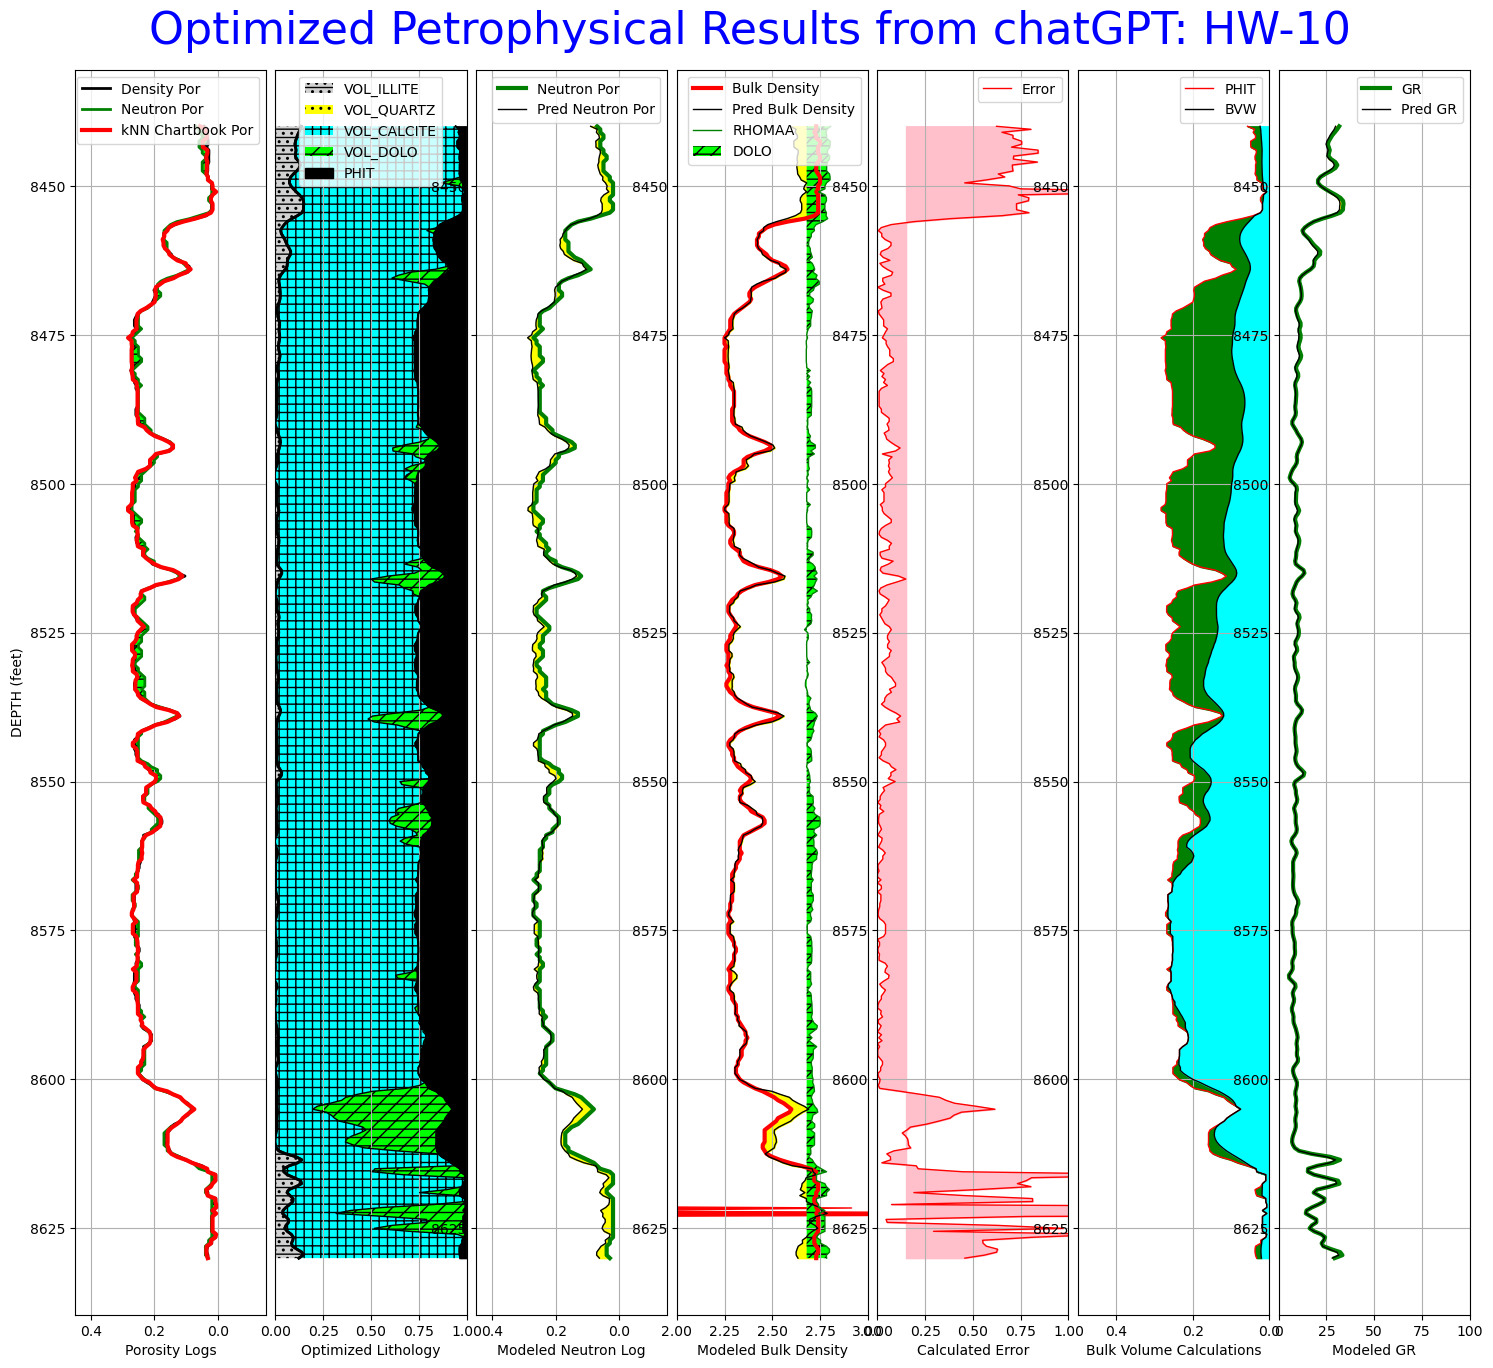

In [60]:
#from scipy.optimize import minimize


'''
# =============================================================================
# # ===========================================================================
# # #--------------------------------------------------------------------------
# ##
# ##            Start Code for Scipy Optimization using minimization
# ##
# # #--------------------------------------------------------------------------
# # ===========================================================================
# =============================================================================
'''
VOL_QUARTZ = []
VOL_CALCITE = []
VOL_DOLO = []
porden =[]
VOL_ILLITE = []
tnph = []
#bvw = []
#bvo=[]
#swt = []

rhob_theoretical = []
tnph_theoretical = []
gr_theoretical   = []
error = []


'''
deptharray.append(Dep[k]);          # Taken from logs
RHOMAA_array.append(RHOMAA[k]);     # Taken from Log data
Porosity_array.append(Porosity[k]); # Taken from log data
porarray.append(por_est_knn);       # Calculated from logs 
rhoarray.append(rhomatrix_est_knn); # Calculated from logs
'''
if tools == 'Neutron_Density':    
    #log Data
    for k in range(0,len(df_log) ,1):  

        TNPH    = CNL[k]
        RHOB2   = RHOB[k]
        GR      = gr[k]
        ILD     = ild[k]
        PHIT    = porarray[k]
        RHOMAA2 = rhoarray[k]

        PORDEN  = (RHOMAA2 - RHOB2)/(RHOMAA2 - FD)

        # =================================================================================
        #       Saturation Calculations
        # =================================================================================
        #BVW = PHIT*((1/PHIT**m) * (rw/ILD) )**(1/n)

        #if BVW > PHIT:
        #    BVW=PHIT
        #else:
        #    BVW=BVW

        #Swt = BVW/PHIT
        #BVO = (PHIT*(1-Swt))
        #bvo.append(BVO)
        #swt.append(Swt)    
        #bvw.append(BVW)    

        # =================================================================================
        #       Illite Option Calculations
        # =================================================================================
        if illite_option == 'yes':
            vol_illite = -0.0424035 + 0.00562239*GR
            illite     = vol_illite/(1-PHIT)
        else:
            vol_illite = 0
            illite     = 0


        # =============================================================================
        # # ===========================================================================
        # # #--------------------------------------------------------------------------
        # ##
        # ##         Scipy Optimization for Lithology of Calcite and Dolomite
        # ##
        # # #--------------------------------------------------------------------------
        # # ===========================================================================
        # =============================================================================
        if lith_option == 'Calcite_Dolomite' :   


            # Function to minimize
            def optimization_function(xy):
                RHOB_theoretical = (2.52*illite  + 2.71*xy[0] + GD_dolo*xy[1])*(1-PHIT) + FD*PHIT
                TNPH_theoretical = (0.247*illite + 0*xy[0] + 0.05375*xy[1])*(1-PHIT) + 1.0*PHIT             
                return (RHOB2 - RHOB_theoretical)**2 + (TNPH - TNPH_theoretical)**2

            # constraints

            # bounds
            #bnds = [ (0.05, 1), (0, 1 - 0.05 - 0.05)]
            # Bounds x is 0 to 1 and y is 0 to 1
            bnds = [(0.0, 1.0),(0.0, 1.0)]

                        # constraints
            cons = [
                {'type': 'eq',   'fun': lambda x: illite + x[0] + x[1] - 1}, # sum of xy[0], xy[1] must be equal to 1
                {'type': 'ineq', 'fun': lambda x: x[0] - 0.001}, # xy[0] must be greater than or equal to 0.01
                {'type': 'ineq', 'fun': lambda x: x[1] - 0.001} # xy[1] must be greater than or equal to 0.01
                ]


            result = minimize(optimization_function, x0=[0, 0], constraints = cons, bounds=bnds, method='SLSQP', options={'maxiter': 1000})
            xy_optimal = result.x

            x = xy_optimal[0]
            y = xy_optimal[1]


            VOL_ILLITE.append(vol_illite)             
            VOL_QUARTZ.append(0)
            VOL_CALCITE.append(x*(1-PHIT))
            VOL_DOLO.append(y*(1-PHIT))

            rhob_theoretical.append(( 2.52*illite  + 2.71*x   +   GD_dolo   *y)*(1-PHIT) + FD*PHIT)
            tnph_theoretical.append((0.247*illite  +  0*x     +   0.05375*y)*(1-PHIT) + 1.0*PHIT)
            gr_theoretical.append((160*illite +  11*x     +   8*y)        *(1-PHIT) + 0.0*PHIT)

            #print('Theoretical RHOB =' , round(rhob_theoretical, 3)  , ', RHOB =',RHOB2)                     


        # =============================================================================
        # # ===========================================================================
        # # #--------------------------------------------------------------------------
        # ##
        # ##       Scipy Optimization for Lithology of Quartz, Cakcite and Dolomite
        # ##
        # # #--------------------------------------------------------------------------
        # # ===========================================================================
        # =============================================================================    
        elif lith_option == 'Quartz_Calcite_Dolomite' :   
            if RHOMAA2 > 2.0:



                def optimization_function(xy):
                    RHOB_theoretical = (2.52*illite + 2.65*xy[0] + 2.71*xy[1] + GD_dolo*xy[2])*(1-PHIT) + FD*PHIT
                    TNPH_theoretical = (0.247*illite -0.05*xy[0] + 0*xy[1] + 0.05375*xy[2])*(1-PHIT) + 1.0*PHIT  
                    return (RHOB2 - RHOB_theoretical)**2 + (TNPH - TNPH_theoretical)**2

                # constraints

                # bounds
                bnds = [(0, 1), (0, 1), (0, 1)]

                # constraints
                cons = [
                    {'type': 'eq', 'fun': lambda x: illite + x[0] + x[1] + x[2] - 1}, # sum of xy[0], xy[1], xy[2] must be equal to 1
                    {'type': 'ineq', 'fun': lambda x: x[0] - 0.001}, # xy[0] must be greater than or equal to 0.01
                    {'type': 'ineq', 'fun': lambda x: x[1] - 0.001}, # xy[1] must be greater than or equal to 0.01
                    {'type': 'ineq', 'fun': lambda x: x[2] - 0.001}  # xy[1] must be greater than or equal to 0.01 
                ]


                result = minimize(optimization_function, x0=[0, 0, 0], constraints=cons, bounds=bnds, method='SLSQP', options={'maxiter': 1000})

                xy_optimal = result.x


                x = xy_optimal[0]
                y = xy_optimal[1]
                z = xy_optimal[2]



                VOL_ILLITE.append(vol_illite)
                VOL_QUARTZ.append(x*(1-PHIT))
                VOL_CALCITE.append(y*(1-PHIT))
                VOL_DOLO.append(z*(1-PHIT))

                rhob_theoretical.append((2.520*illite + 2.65*x + 2.71*y + GD_dolo   *z)*(1-PHIT) + FD*PHIT)
                tnph_theoretical.append((0.247*illite - 0.05*x + 0.0*y  + 0.05373*z)*(1-PHIT) + 1.0*PHIT)
                gr_theoretical.append((160*illite + 1*x +  11*y     +   8*z)        *(1-PHIT) + 0.0*PHIT)

                #print('Theoretical RHOB =' , round(rhob_theoretical, 3)  , ', RHOB =',RHOB2)                     



            else:

                VOL_ILLITE.append(vol_illite)
                VOL_QUARTZ.append(1-PHIT)
                VOL_CALCITE.append(0)
                VOL_DOLO.append(0)

                rhob_theoretical.append(0)
                tnph_theoretical.append(0)
                error.append(0)       


        porden.append(PORDEN)   
        tnph.append(TNPH)

        rhob_norm = (RHOB[k] - 1.9) / (3.0 - 1.9)
        rhob_norm_theo = (rhob_theoretical[k] - 1.9) / (3.0 - 1.9)
        tnph_norm = (CNL[k] - (-0.05)) / (0.6 - (-0.05))
        tnph_norm_theo = (tnph_theoretical[k] - (-0.05)) / (0.6 - (-0.05))     

        error.append(0.5*abs((rhob_norm-rhob_norm_theo)+(tnph_norm-tnph_norm_theo))/(PHIT))

elif tools == 'Neutron_Density_GR': 
    
    #log Data
    for k in range(0,len(df_log) ,1):  

        TNPH    = CNL[k]
        RHOB2   = RHOB[k]
        GR      = gr[k]
        ILD     = ild[k]
        PHIT    = porarray[k]
        RHOMAA2 = rhoarray[k]

        PORDEN  = (RHOMAA2 - RHOB2)/(RHOMAA2 - FD)

        # =================================================================================
        #       Saturation Calculations
        # =================================================================================
        #BVW = PHIT*((1/PHIT**m) * (rw/ILD) )**(1/n)

        #if BVW > PHIT:
        #    BVW=PHIT
        #else:
        #    BVW=BVW

        #Swt = BVW/PHIT
        #BVO = (PHIT*(1-Swt))
        #bvo.append(BVO)
        #swt.append(Swt)    
        #bvw.append(BVW)    

        # =================================================================================
        #       Illite Option Calculations
        # =================================================================================
        if illite_option == 'yes':
            vol_illite = -0.0424035 + 0.00562239*GR
            illite     = vol_illite/(1-PHIT)
        else:
            vol_illite = 0
            illite     = 0


        # =============================================================================
        # # ===========================================================================
        # # #--------------------------------------------------------------------------
        # ##
        # ##         Scipy Optimization for Lithology of Calcite and Dolomite
        # ##
        # # #--------------------------------------------------------------------------
        # # ===========================================================================
        # =============================================================================
        if lith_option == 'Calcite_Dolomite' :   


            # Function to minimize
            def optimization_function(xy):
                RHOB_theoretical = (2.52*illite  + 2.71*xy[0] + GD_dolo*xy[1])*(1-PHIT) + 1.2*PHIT
                TNPH_theoretical = (0.247*illite + 0*xy[0] + 0.05375*xy[1])*(1-PHIT) + 1.0*PHIT    
                GR_theoretical   = (160*illite + GR_calc*xy[0] + GR_dolo*xy[1])*(1-PHIT) + 0.0*PHIT
                return (RHOB2 - RHOB_theoretical)**2 + (TNPH - TNPH_theoretical)**2 + (GR - GR_theoretical)**2

            # constraints

            # bounds
            #bnds = [ (0.05, 1), (0, 1 - 0.05 - 0.05)]
            # Bounds x is 0 to 1 and y is 0 to 1
            bnds = [(0.0, 1.0),(0.0, 1.0)]

                        # constraints
            cons = [
                {'type': 'eq',   'fun': lambda x: illite + x[0] + x[1] - 1}, # sum of xy[0], xy[1] must be equal to 1
                #{'type': 'eq',   'fun': lambda x: (illite + x[0] + x[1])*(1-PHIT) + PHIT - 1}, # sum of xy[0], xy[1] must be equal to 1 
                {'type': 'ineq', 'fun': lambda x: x[0] - 0.001}, # xy[0] must be greater than or equal to 0.01
                {'type': 'ineq', 'fun': lambda x: x[1] - 0.001} # xy[1] must be greater than or equal to 0.01
                ]


            result = minimize(optimization_function, x0=[0, 0], constraints = cons, bounds=bnds, method='SLSQP', options={'maxiter': 1000})
            xy_optimal = result.x

            x = xy_optimal[0]
            y = xy_optimal[1]


            VOL_ILLITE.append(vol_illite)             
            VOL_QUARTZ.append(0)
            VOL_CALCITE.append(x*(1-PHIT))
            VOL_DOLO.append(y*(1-PHIT))

            rhob_theoretical.append(( 2.52*illite  + 2.71*x   +   GD_dolo*y)*(1-PHIT) + FD*PHIT)
            tnph_theoretical.append((0.247*illite  +  0*x     +   0.05375*y)*(1-PHIT) +    PHIT)
            gr_theoretical.append((160*illite +  GR_calc*x     +   GR_dolo*y)        *(1-PHIT) + 0.0*PHIT)

            #print('Theoretical RHOB =' , round(rhob_theoretical, 3)  , ', RHOB =',RHOB2)                     


        # =============================================================================
        # # ===========================================================================
        # # #--------------------------------------------------------------------------
        # ##
        # ##       Scipy Optimization for Lithology of Quartz, Cakcite and Dolomite
        # ##
        # # #--------------------------------------------------------------------------
        # # ===========================================================================
        # =============================================================================    
        elif lith_option == 'Quartz_Calcite_Dolomite' :   
            if RHOMAA2 > 2.0:



                def optimization_function(xy):
                    RHOB_theoretical = (2.52*illite + 2.65*xy[0] + 2.71*xy[1] + GD_dolo*xy[2])*(1-PHIT) + 1.2*PHIT
                    TNPH_theoretical = (0.247*illite -0.05*xy[0] + 0*xy[1] + 0.05375*xy[2])*(1-PHIT) + 1.0*PHIT 
                    GR_theoretical   = (160*illite + 1*xy[0] + GR_calc*xy[1] + GR_dolo*xy[2])*(1-PHIT) + 0.0*PHIT
                    return (RHOB2 - RHOB_theoretical)**2 + (TNPH - TNPH_theoretical)**2 + (GR - GR_theoretical)**2

                # constraints

                # bounds
                bnds = [(0, 1), (0, 1), (0, 1)]

                # constraints
                cons = [
                    {'type': 'eq', 'fun': lambda x: illite + x[0] + x[1] + x[2] - 1}, # sum of xy[0], xy[1], xy[2] must be equal to 1
                    {'type': 'ineq', 'fun': lambda x: x[0] - 0.001}, # xy[0] must be greater than or equal to 0.01
                    {'type': 'ineq', 'fun': lambda x: x[1] - 0.001}, # xy[1] must be greater than or equal to 0.01
                    {'type': 'ineq', 'fun': lambda x: x[2] - 0.001}  # xy[1] must be greater than or equal to 0.01 
                ]


                result = minimize(optimization_function, x0=[0, 0, 0], constraints=cons, bounds=bnds, method='SLSQP', options={'maxiter': 1000})

                xy_optimal = result.x


                x = xy_optimal[0]
                y = xy_optimal[1]
                z = xy_optimal[2]



                VOL_ILLITE.append(vol_illite)
                VOL_QUARTZ.append(x*(1-PHIT))
                VOL_CALCITE.append(y*(1-PHIT))
                VOL_DOLO.append(z*(1-PHIT))

                rhob_theoretical.append((2.520*illite + 2.65*x + 2.71*y + GD_dolo*z)*(1-PHIT) + 1.2*PHIT)
                tnph_theoretical.append((0.247*illite - 0.05*x + 0.0*y  + 0.05373*z)*(1-PHIT) + 1.0*PHIT)
                gr_theoretical.append((160*illite + 1*x +  GR_calc*y     +   GR_dolo*z)        *(1-PHIT) + 0.0*PHIT)
                #print('Theoretical RHOB =' , round(rhob_theoretical, 3)  , ', RHOB =',RHOB2)                     



            else:

                VOL_ILLITE.append(vol_illite)
                VOL_QUARTZ.append(1-PHIT)
                VOL_CALCITE.append(0)
                VOL_DOLO.append(0)

                rhob_theoretical.append(0)
                tnph_theoretical.append(0)
                error.append(0)       


        porden.append(PORDEN)   
        tnph.append(TNPH)

        rhob_norm = (RHOB[k] - 1.9)/(3.0 - 1.9)
        rhob_norm_theo = (rhob_theoretical[k] - 1.9)/(3.0 - 1.9)
        tnph_norm = ( CNL[k] - (-0.05))/(0.6 - (-0.05))
        tnph_norm_theo = (tnph_theoretical[k] - (-0.05))/(0.6 - (-0.05))    
        gr_norm = ( gr[k] -  0)/(150 - 0)
        gr_norm_theo = (gr_theoretical[k] - 0)/(150 - 0)    


        error.append(0.333*abs((rhob_norm-rhob_norm_theo)+(tnph_norm-tnph_norm_theo)+(gr_norm-gr_norm_theo))/(PHIT))
 
    
'''
# =============================================================================
#      Display Optimization Petrophysics
# ============================================================================='''
Optimization_plot()


# 4) Permeability Estimations from kNN:
### Import the Permeability calibration data and then make the Perm estimations.

In [61]:
#!/usr/bin/env python3
# python loglan

# =============================================================================
# # ===========================================================================
# # #-------------------------------------------------------------------------- 
# # #        Read in Reference HW data (_r) from Excel file
# # #        Read in the reference Core data 
# # #        
# # #--------------------------------------------------------------------------
# # ===========================================================================
# =============================================================================

#read the Excel .xlsx file 
file = r'./data/HW_Phit_Rhob_GR_Perm.xlsx'
core_data = pd.read_excel(file,index_col=False)
core_data = core_data.replace(-999.25,np.nan)


Por_r   = core_data['PHIT']
Rhob_r  = core_data['RHOB']
GR_r    = core_data['GR']
Kair_r  = np.log10(core_data['PERMEABILITY'])

#print(gr)

## kNN Nearest Neighbors estimation of Permeability: 

381


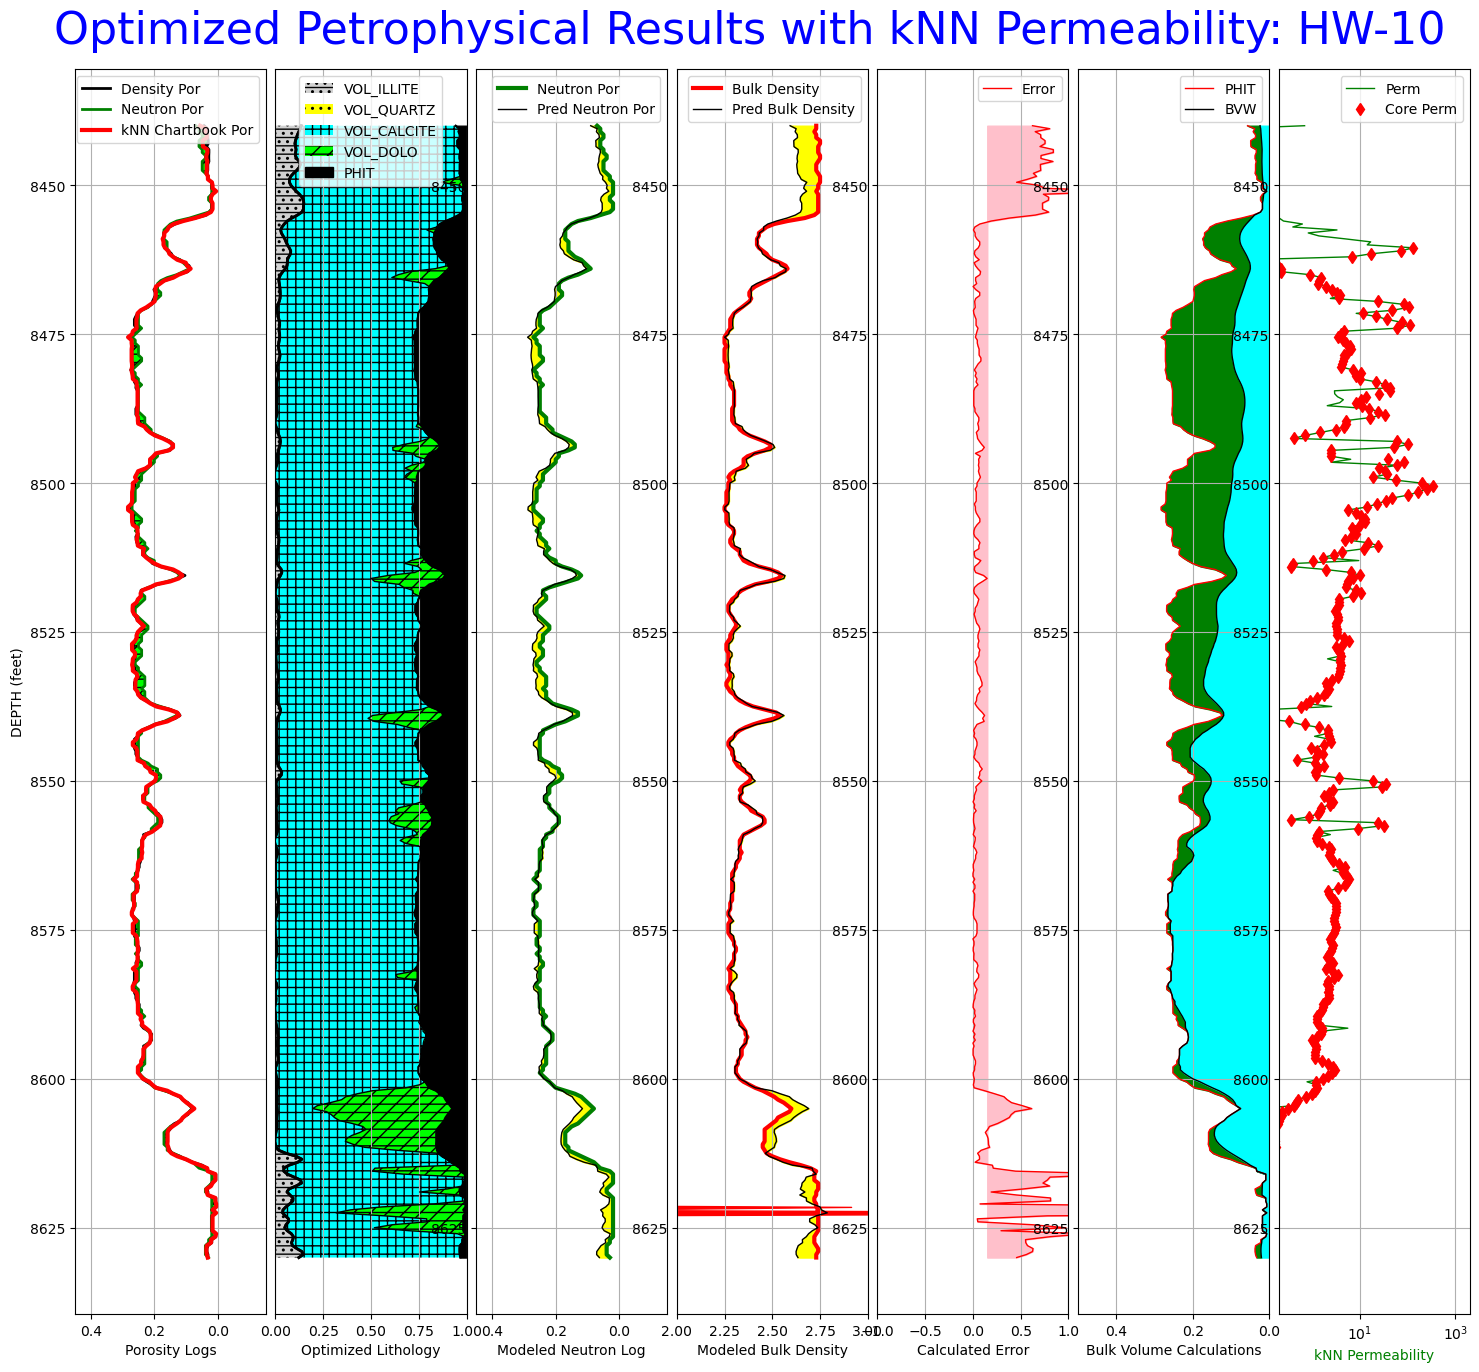

In [62]:
n_neighbors = 3

# =============================================================================
# # ===========================================================================
# # #--------------------------------------------------------------------------
# # #
# # #            This is the beginnin of kNN for Permeability Estimations
# # #
# # #--------------------------------------------------------------------------
# # ===========================================================================
# =============================================================================
    
#porarray.append(por_est_knn);       # Calculated Chartbook Porosity 
#permarray  = []
perm = []

#print(len(porarray),len(swt))



# Load data from geolog
#while geolog.getrow():
for k in range(0,len(df_log) ,1):  


    # =============================================================================
    # # ===========================================================================
    # # #--------------------------------------------------------------------------
    # # #           
    # # #            Read in log data 
    # # #                   
    # # #--------------------------------------------------------------------------
    # # ===========================================================================
    # =============================================================================
    Por = porarray[k]
    Rhob = RHOB[k]
    GR   = gr[k]


    # =============================================================================
    # # ===========================================================================
    # # #--------------------------------------------------------------------------
    # # #
    # # #            This is the beginnin of kNN for Permeability Estimations
    # # #
    # # #--------------------------------------------------------------------------
    # # ===========================================================================
    # =============================================================================
        
    permarray  = []

    inv_dist_array = []
    distance_knn_array = []


    #for k in range(0,len(NMR_data) ,1):  
    por_norm = ((Por -  0)/(.4 - 0))
    rhob_norm = (Rhob-2)/(3-2)
    gr_norm   = (GR - 0)/(100-0)

    dist_inv    = []
    dist_phi    = []
    dist_rhob   = []
    dist_gr     = []
    Perm_weight = []
    Por_r_norm  = []
    Rhob_r_norm = []
    GR_r_norm   = []

    dist_inv_total = 0
    Perm_total     = 0
    
    
    
    #this is the reference_data being used with kNN
    for i in range(0,len(core_data),1): 

        # Normalize the core reference data of Por_r and swt_r
        Por_r_norm.append((Por_r[i]   -  0)/(0.4 - 0))
        Rhob_r_norm.append((Rhob_r[i] -  2)/(3   - 2))
        GR_r_norm.append((GR_r[i]     -  0)/(100 - 0))
         
                              
        # Compute Euclidian Distance inverse distance
        dist_phi.append(abs(por_norm - Por_r_norm[i]))
        dist_rhob.append(abs(rhob_norm - Rhob_r_norm[i]))
        dist_gr.append(abs(gr_norm - GR_r_norm[i]))
        dist_inv.append(1/(math.sqrt(dist_phi[i]**2 + dist_rhob[i]**2 + dist_gr[i]**2) + 0.0000001))

        # Calculalte inverse distance weights for perm
        Perm_weight.append(dist_inv[i]  * Kair_r[i])
        inv_dist_array.append(dist_inv[i]);  # add items

        # =============================================================================
        ###                    KNN Array for all data
        # # ===========================================================================
        # # #--------------------------------------------------------------------------
        distance_knn_array = [dist_inv, Perm_weight]
        #
        # # #--------------------------------------------------------------------------
        # # ===========================================================================
        # =============================================================================

    # =============================================================================
    # # ===========================================================================
    # # #--------------------------------------------------------------------------
    # # #           
    # # #               Transpose and Sort kNN array
    # # #                   
    # # #--------------------------------------------------------------------------
    # # ===========================================================================
    # =============================================================================

    #knn_array = np.transpose array
    knn_array = np.transpose(distance_knn_array)

    #matsor x[x[:,column].argsort()[::-1]] and -1 us reverse order
    mat_sort = knn_array[knn_array[:,0].argsort()[::-1]] #firt column reverse sort (-1)

    # =============================================================================
    # # ===========================================================================
    # # #--------------------------------------------------------------------------
    # # #           
    # # #               Calculate knn Thomeer Parameters
    # # #                   
    # # #--------------------------------------------------------------------------
    # # ===========================================================================
    # =============================================================================
    #------------------------------------------------------------------------------
    #    Number of nearest Neighbors set in loglan constans
    #------------------------------------------------------------------------------
    #n_neighbors = 3
    #------------------------------------------------------------------------------

    dist_inv_total_knn = 0
    Perm_total_knn = 0


    #kNN Estimates for first n rows

    for i in range(0,n_neighbors,1):
        dist_inv_total_knn = dist_inv_total_knn + mat_sort[i][0]
        Perm_total_knn  = Perm_total_knn + mat_sort[i][1]

    #back to k values and calculate estimations now
    perm_est_knn = (10**(Perm_total_knn  / dist_inv_total_knn))
    
    if perm_est_knn < 0.001:
        perm_est_knn = 0.001
        
    perm.append(perm_est_knn)
  
print(len(perm))

'''
# =============================================================================
#      Display Optimization Petrophysics with Permeability
# ============================================================================='''
Perm_plot()

# 5) Estimate Thomeer Parameters using kNN to Calculate Capillary Pressure Saturations:
### Read in Rosetta Stone HPMI Thomeer Parameter Reference Calibration Data.

In [63]:
#read the Excel .xlsx file - slow
#file = r'./data/mapinv_reference_data_carbonates_calculatedMode_Rosetta.xlsx'
file = r'./data/costa_hpmi_thomeer.xlsx'

thomeer_core_data = pd.read_excel(file,index_col=False)
thomeer_core_data = thomeer_core_data.replace(-999.25,np.nan)


Permeability_r = thomeer_core_data['PERMEABILITY']
Porosity_r = thomeer_core_data['POROSITY']
G1_r = thomeer_core_data['G1']
PD1_r = thomeer_core_data['PD1']
G2_r = thomeer_core_data['G2']
PD2_r = thomeer_core_data['PD2']
BV1_r = thomeer_core_data['BV1']
BV2_r = thomeer_core_data['BV2']
Mode_r = thomeer_core_data['Mode']
ROCK_INDEX_r = thomeer_core_data['ROCK_INDEX']    


## kNN used to Estimate Thomeer Parameters (Pd, G and BVocc) and Rock Index (PRT):

/var/folders/lf/9hqr0q153ls52s9btzjc56080000gp/T/ipykernel_77246/3226917130.py:115: RuntimeWarning: divide by zero encountered in log10
  Permeability_norm.append((np.log10(Permeability_r[i]) - perm_min) / (perm_max - perm_min))


381
381
381


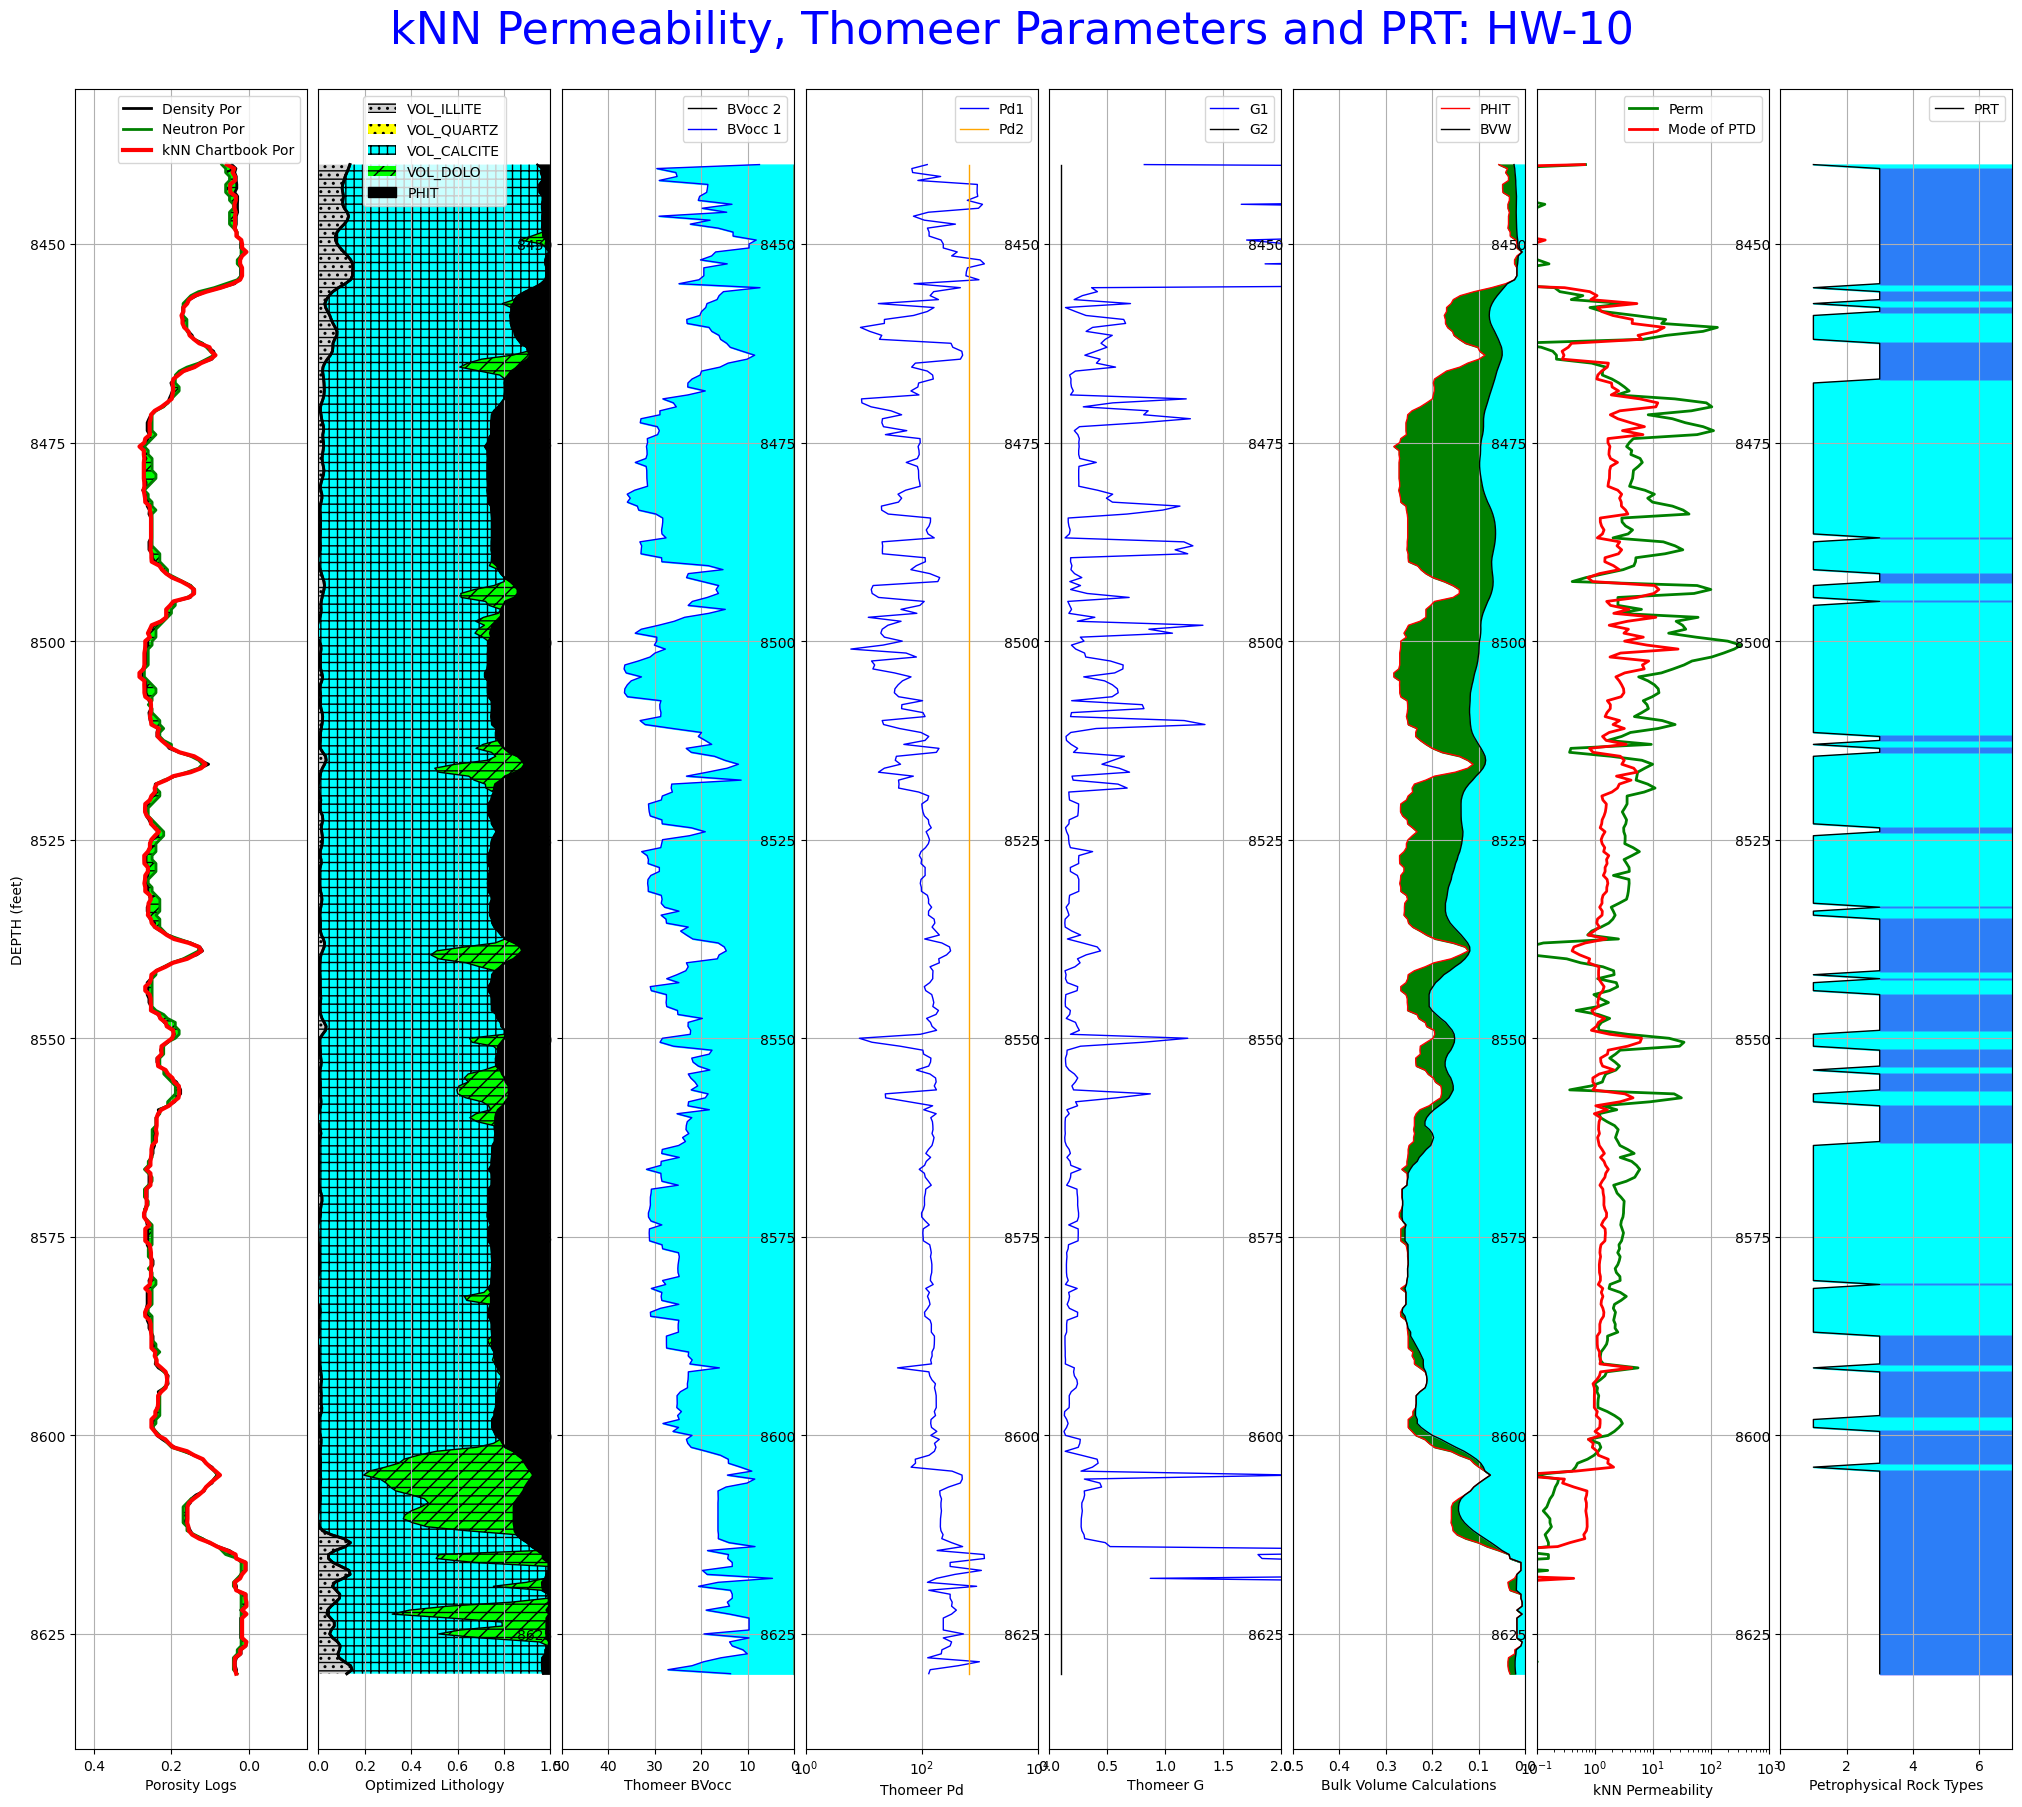

In [64]:
from collections import Counter 


por_min = 0
por_max = 0.4
perm_min = -4
perm_max = 4

g1_est_knn  = []
pd1_est_knn = []
bv1_est_knn = []
g2_est_knn  = []
pd2_est_knn = []
bv2_est_knn = []
mode=[]



def most_frequent(List): 
    occurence_count = Counter(List) 
    return occurence_count.most_common(1)[0][0]


#List = [mat_sort[0][7],mat_sort[1][7],mat_sort[2][7],mat_sort[3][7],mat_sort[4][7]]

rock_index_knn = []
rock_type = []
mode=[]

#mode = math.exp(-1.15*g1_est_knn) * (214/pd1_est_knn)
#Rock_Index_est_knn = int(Rock_Index_total_knn / n_neighbors)


for k in range(0,len(df_log) ,1):  
    
   # =============================================================================
    # # ===========================================================================
    # # #--------------------------------------------------------------------------
    # # #           
    # # #            Read in log data from Geolog
    # # #                   
    # # #--------------------------------------------------------------------------
    # # ===========================================================================
    # =============================================================================

    #phit/0.95 is an approximation for ambient core porosity to query the Rosetta Stone data
    Por = porarray[k]/0.95
    Perm = perm[k]


    # =============================================================================
     # # ===========================================================================
    # # #--------------------------------------------------------------------------
    # # #
    # # #            This is the beginning of kNN for Thomeer parameter Estimations
    # # #
    # # #--------------------------------------------------------------------------
    # # ===========================================================================
    # =============================================================================
 
    #normalized Geolog well Porosity and Permeability data
    por_norm  = (Por-por_min) / (por_max - por_min)
    perm_norm = (np.log10(Perm) - perm_min) / (perm_max - perm_min) 
 
    # =============================================================================
    # #---------------------------------------------------------------------------- 
    # #           
    # #              ESTIMATE THOMEER PARAMETERS FOR BOTH PORE SYSTEMS
    # #                   
    # #----------------------------------------------------------------------------
    # =============================================================================

    dist_inv = []
    dist_phi = []
    dist_lperm = []
    G1_weight = []
    PD1_weight = []
    BV1_weight = []
    G2_weight = []
    PD2_weight = []
    BV2_weight = []
    #Rock_Index_weight = []


    dist_inv_total=0
    G1_total  = 0
    PD1_total = 0
    BV1_total = 0
    G2_total  = 0
    PD2_total = 0
    BV2_total = 0




    inv_dist_array = []
    #distance_knn_array = [rows,columns]
    distance_knn_array = []


    #------------------------------------------------------------------ 
    #               Estimate all Thomeer Parameters for *_est values
    #-------------------------------------------------------------------

    Porosity_norm     = []
    Permeability_norm = []


    '''
    This is the Reference Data being used here
    '''
    for i in range(0,len(thomeer_core_data),1):

        Porosity_norm.append((Porosity_r[i] - por_min) / (por_max - por_min))
        Permeability_norm.append((np.log10(Permeability_r[i]) - perm_min) / (perm_max - perm_min))
        
        #Euclidian Distance
        dist_phi.append(   abs(por_norm  - Porosity_norm[i]    ))  
        dist_lperm.append( abs(perm_norm - Permeability_norm[i]))
        dist_inv.append( 1  /  math.sqrt(  dist_phi[i]**2 + dist_lperm[i]**2)  )

        
        #calculalte weights for each
        G1_weight.append(dist_inv[i]  * G1_r[i])
        PD1_weight.append(dist_inv[i] * PD1_r[i])
        BV1_weight.append(dist_inv[i] * BV1_r[i])
        G2_weight.append(dist_inv[i]  * G2_r[i])
        PD2_weight.append(dist_inv[i] * PD2_r[i])
        BV2_weight.append(dist_inv[i] * BV2_r[i])
        #Rock_Index_weight.append(dist_inv[i] * Rock_Index[i])
        


        inv_dist_array.append(dist_inv[i]);  # add items

    # =============================================================================
    ###                    Create the KNN Array
    # # ===========================================================================
    # # #--------------------------------------------------------------------------
        distance_knn_array = [dist_inv, G1_weight, PD1_weight, BV1_weight, G2_weight, PD2_weight, BV2_weight, ROCK_INDEX_r]
    #        distance_knn_array = [Permeability, Porosity, G1, PD1, BV1, G2, PD2, BV2]
    # # #--------------------------------------------------------------------------
    # # ===========================================================================
    # =============================================================================
    #xnorm=np.array(Porosity_norm)
    #ynorm=np.array(Permeability_norm)


    # =============================================================================
    # # ===========================================================================
    # # #--------------------------------------------------------------------------
    # # #           
    # # #               Transpose and Sort the kNN array
    # # #                   
    # # #--------------------------------------------------------------------------
    # # ===========================================================================
    # =============================================================================

    #knn_array = np.transpose array
    knn_array = np.transpose(distance_knn_array)
    #print(knn_array)

    #Sort array from large to low by column 0 which is dist_inv 
    #xknn=np.array(knn_array)

    #matsor x[x[:,column].argsort()[::-1]] and -1 us reverse order
    mat_sort = knn_array[knn_array[:,0].argsort()[::-1]] #firt column reverse sort (-1)
    #mat_sort = x[x[:,1].argsort()[::-1]]
    #mat_sort = x[x[:,2].argsort()[::-1]]



    # =============================================================================
    # # ===========================================================================
    # # #--------------------------------------------------------------------------
    # # #           
    # # #               Calculate knn Thomeer Parameters
    # # #                   
    # # #--------------------------------------------------------------------------
    # # ===========================================================================
    # =============================================================================


    #------------------------------------------------------------------------------
    #    Number of nearest Neighbors
    #------------------------------------------------------------------------------
    n_neighbors = 3
    #------------------------------------------------------------------------------

    dist_inv_total_knn = 0
    G1_total_knn = 0
    PD1_total_knn = 0
    BV1_total_knn = 0
    G2_total_knn = 0
    PD2_total_knn = 0
    BV2_total_knn = 0
    #Rock_Index_total_knn = 0



    #kNN Estimates for first 3 rows
    #dist_inv_total = mat_sort[0][0] + mat_sort[1][0] + mat_sort[2][0]
    for i in range(0,n_neighbors,1):
        dist_inv_total_knn = dist_inv_total_knn + mat_sort[i][0]
        G1_total_knn  = G1_total_knn + mat_sort[i][1]
        PD1_total_knn = PD1_total_knn + mat_sort[i][2]
        BV1_total_knn = BV1_total_knn + mat_sort[i][3]
        G2_total_knn  = G2_total_knn + mat_sort[i][4]
        PD2_total_knn = PD2_total_knn + mat_sort[i][5]
        BV2_total_knn = BV2_total_knn + mat_sort[i][6]
        #Rock_Index_total_knn = Rock_Index_total_knn + mat_sort[i][7]
        #print(mat_sort[i][7])
        
        
    # Estimate Thomeer parameters to be written into Geolog well
    g1_est_knn.append(G1_total_knn  / dist_inv_total_knn)
    pd1_est_knn.append( PD1_total_knn / dist_inv_total_knn)
    bv1_est_knn.append( BV1_total_knn / dist_inv_total_knn)
    #g2_est_knn.append( G2_total_knn  / dist_inv_total_knn)
    #pd2_est_knn.append( PD2_total_knn / dist_inv_total_knn)
    #bv2_est_knn.append( BV2_total_knn / dist_inv_total_knn)
    mode.append(  math.exp(-1.15*g1_est_knn[k]) * (214/pd1_est_knn[k]) )

    
    
    '''
    The Costa HPMI Thomeer results do not have enough 2nd Pore system data to model this pore system.
    if you are using the Rosetta Stone data, then please comment out the following lines. 
    '''
    g2_est_knn.append( .1)
    pd2_est_knn.append( 650)
    bv2_est_knn.append( 0)

    
    
    
    '''
    # =============================================================================
    # # ===========================================================================
    # # #--------------------------------------------------------------------------
    # # #           
    # # #              Rock Type from Most Common in KNN series
    # # #--------------------------------------------------------------------------
    # # ===========================================================================
    # =============================================================================      
    '''
    
    List = []    
    
    for d in range(0,n_neighbors):
        List.append(mat_sort[d,7])
    
    most_frequent(List)   == rock_index_knn
    
    
    #print(most_frequent(List)) 
    if most_frequent(List)   == 1:
        rock_index_knn.append(1)

         
    elif most_frequent(List) == 2: 
        rock_index_knn.append(3)

         
    elif most_frequent(List) == 3:
        rock_index_knn.append(3)

         
    elif most_frequent(List) == 4:
        rock_index_knn.append(4)

    
    elif most_frequent(List) == 5:
        rock_index_knn.append(5)

         
    else:
        rock_index_knn.append(6)

   
print(len(rock_index_knn))
print(len(bv1_est_knn))
print(len(bv2_est_knn))

'''
# =============================================================================
#      Display Perm and Thomeer Petrophysics
# ============================================================================='''
Thomeer_plot()

# 6) Thomeer Capillary Pressure Bulk Volume Oil (BVO) Calculations:

## Free Water Level (FWL) Search
We have provided a FWL Search technique in python too to estimate the FWL elevation (TVDss) in each key well to be used to create a FWL plane for the field. To model Capillary Pressure saturations, it is essential to have a proper Free Water Level (FWL). Reservoir Capillary Pressure or buoyancy is dependent upon the height above the FWL. 

On new discoveries the FWL is usually determined from Formation Test data plotting the pressure data vs. TVDss to find the intersection of the water gradient vs. hydrocarbon gradient. The elevation of this intersection is the FWL or zero Capillary Pressure. However, on older fields, this type of data is typically not available prior to pressure depletion and/or fluid contact movements in the field. Therefore, we need another way to estimate the FWL for the field. In the python software used in our Notebook we offer a FWL search technique that has been shown to work very well in numerous fields.

We perform this well-by-well FWL search by varying the FWL elevation from an estimated highest FWL to the lowest expected FWL (spill point...) for the reservoir.  We then calculate the error difference between the Bulk Volume Oil (BVO) from logs vs. BVO from Thomeer Capillary Pressure at each new FWL estimate for that well. The final fwl_est is the FWL estimated with the lowest Bulk Volume Oil (BVO) error for that well. This fwl_est is then used in our final Thomeer BVO Oil calculations.

The FWL search is usually run on all wells with a fwl_est for each well. In many instances in fields with large hydrocarbon columns, the wells near the crest will be too high above the FWL to give valid results. We have found that the wells near the edge usually give the best estimation. However, those wells affected by water encroachment will also not give valid results. In the end it is usually a small percentage of wells near the edge of the field that will give valid FWL estimates that are consistent. The search results from these wells are then typically used to construct a plane in the 3D fine-grid model to represent the FWL for the field.

It should be noted, that not all FWL surfaces are flat. Structural tilting, subduction, and dynamic aquifers... can result in a tilted FWL elevations with the possibility of residual oil below the FWL, depending in the situation. 

In [65]:
print(elev_meas_ref)

397


In [66]:
#elev_meas_ref = 397

tcosthetaww = 12
rho_f = 1.135
rho_hc = 0.837

bvo_error_temp=222


FWL_UPPER_ESTIMATE = 8100
FWL_LOWER_ESTIMATE = 8300

# loop through FWL Search from 8100 to 8300 steps 
for fwl in range(FWL_UPPER_ESTIMATE, FWL_LOWER_ESTIMATE,2):

    
    h=[]
    PcRes=[]
    PcHg=[]
    por_upscale_fact=[]
    bvocc1=[]
    bvocc2=[]
    bvo_thomeer=[]
    bvo_error=[]
    bvo_error_sum=0
    bvo_error_level=[]
    sw_thomeer=[] 


    # Load log data from df
    for k in range(0,len(df_log) ,1):  

        # =============================================================================
        # # ===========================================================================
        # # #--------------------------------------------------------------------------
        # # #
        # # #            Calculate Thomeer-based BVO Saturations
        # # #
        # # #--------------------------------------------------------------------------
        # # ===========================================================================
        # =============================================================================

        h.append(fwl - (Dep[k]-elev_meas_ref))  #Works Well


        PcRes.append(h[k] *0.433*(rho_f - rho_hc))
        PcHg.append((367/tcosthetaww)*PcRes[k])   

        #------------- Thomeer Upscale Porosity Correction Factor  ------------------------

        bv1=bv1_est_knn[k]/100
        bv2=bv2_est_knn[k]/100

        if porarray[k] > 0.01:
            por_upscale_fact.append((0.1629 * math.log(porarray[k]) + 1.2923) * (porarray[k]/(bv1+bv2)) )
        else:
            por_upscale_fact.append(0.55)

        #------- End of Thomeer Porosity Upscale Correction Factor---------------------------



        #---------------  Calculalte Bulk Volume Occupied at each well-level ----------------
        if PcHg[k] > pd1_est_knn[k]:
            #bvocc1 = bv1*bv_upscale_fact * 10**(-0.434*g1/math.log10(((367/tcosthetaww)*h*0.433*(rho_f - rho_hc))/pd1))
            bvocc1.append(bv1*por_upscale_fact[k]*10**(-0.434*g1_est_knn[k]/math.log10(PcHg[k]/pd1_est_knn[k]))) 

        else:
            bvocc1.append(0.001)

        if PcHg[k] > pd2_est_knn[k]:
            #bvocc2 = bv2*bv_upscale_fact * 10**(-0.434*g2/math.log10(((367/tcosthetaww)*h*0.433*(rho_f - rho_hc))/pd2))
            bvocc2.append(bv2*por_upscale_fact[k]*10**(-0.434*g2_est_knn[k]/math.log10(PcHg[k]/pd2_est_knn[k]))) 
        else:
            bvocc2.append(0.001)



        #---------   Calculate BVO Error  ------------------------------------------------
        bvo_thomeer.append( bvocc1[k] + bvocc2[k])
        sw_thomeer.append(1 - bvo_thomeer[k]/porarray[k])
        bvo_error.append(abs(bvo[k]-bvo_thomeer[k]))
        #print(bvo_error[k],fwl) 
        bvo_error_sum=(bvo_error_sum + bvo_error[k])
    
 


    if bvo_error_sum<bvo_error_temp:
        fwl_est = fwl

    print('FWL Try=',fwl,'\t','BVO_Error_Sum =', bvo_error_sum,'\t','fwl_est =',fwl_est)
    
    bvo_error_temp=bvo_error_sum

print()
print()

FWL Try= 8100 	 BVO_Error_Sum = 22.538192750384194 	 fwl_est = 8100
FWL Try= 8102 	 BVO_Error_Sum = 22.20526453640838 	 fwl_est = 8102
FWL Try= 8104 	 BVO_Error_Sum = 21.90990655379224 	 fwl_est = 8104
FWL Try= 8106 	 BVO_Error_Sum = 21.512274623876788 	 fwl_est = 8106
FWL Try= 8108 	 BVO_Error_Sum = 21.027766036230087 	 fwl_est = 8108
FWL Try= 8110 	 BVO_Error_Sum = 20.638252351621706 	 fwl_est = 8110
FWL Try= 8112 	 BVO_Error_Sum = 20.06655052467389 	 fwl_est = 8112
FWL Try= 8114 	 BVO_Error_Sum = 19.47896251263905 	 fwl_est = 8114
FWL Try= 8116 	 BVO_Error_Sum = 18.973948037579238 	 fwl_est = 8116
FWL Try= 8118 	 BVO_Error_Sum = 18.535094078968907 	 fwl_est = 8118
FWL Try= 8120 	 BVO_Error_Sum = 18.131604259565265 	 fwl_est = 8120
FWL Try= 8122 	 BVO_Error_Sum = 17.745162672787025 	 fwl_est = 8122
FWL Try= 8124 	 BVO_Error_Sum = 17.345877139126895 	 fwl_est = 8124
FWL Try= 8126 	 BVO_Error_Sum = 16.91564245507381 	 fwl_est = 8126
FWL Try= 8128 	 BVO_Error_Sum = 16.423446426722467 	 

### Final Thomeer BVO calculations from the above FWL Search results: 

8180 381 381 381 381


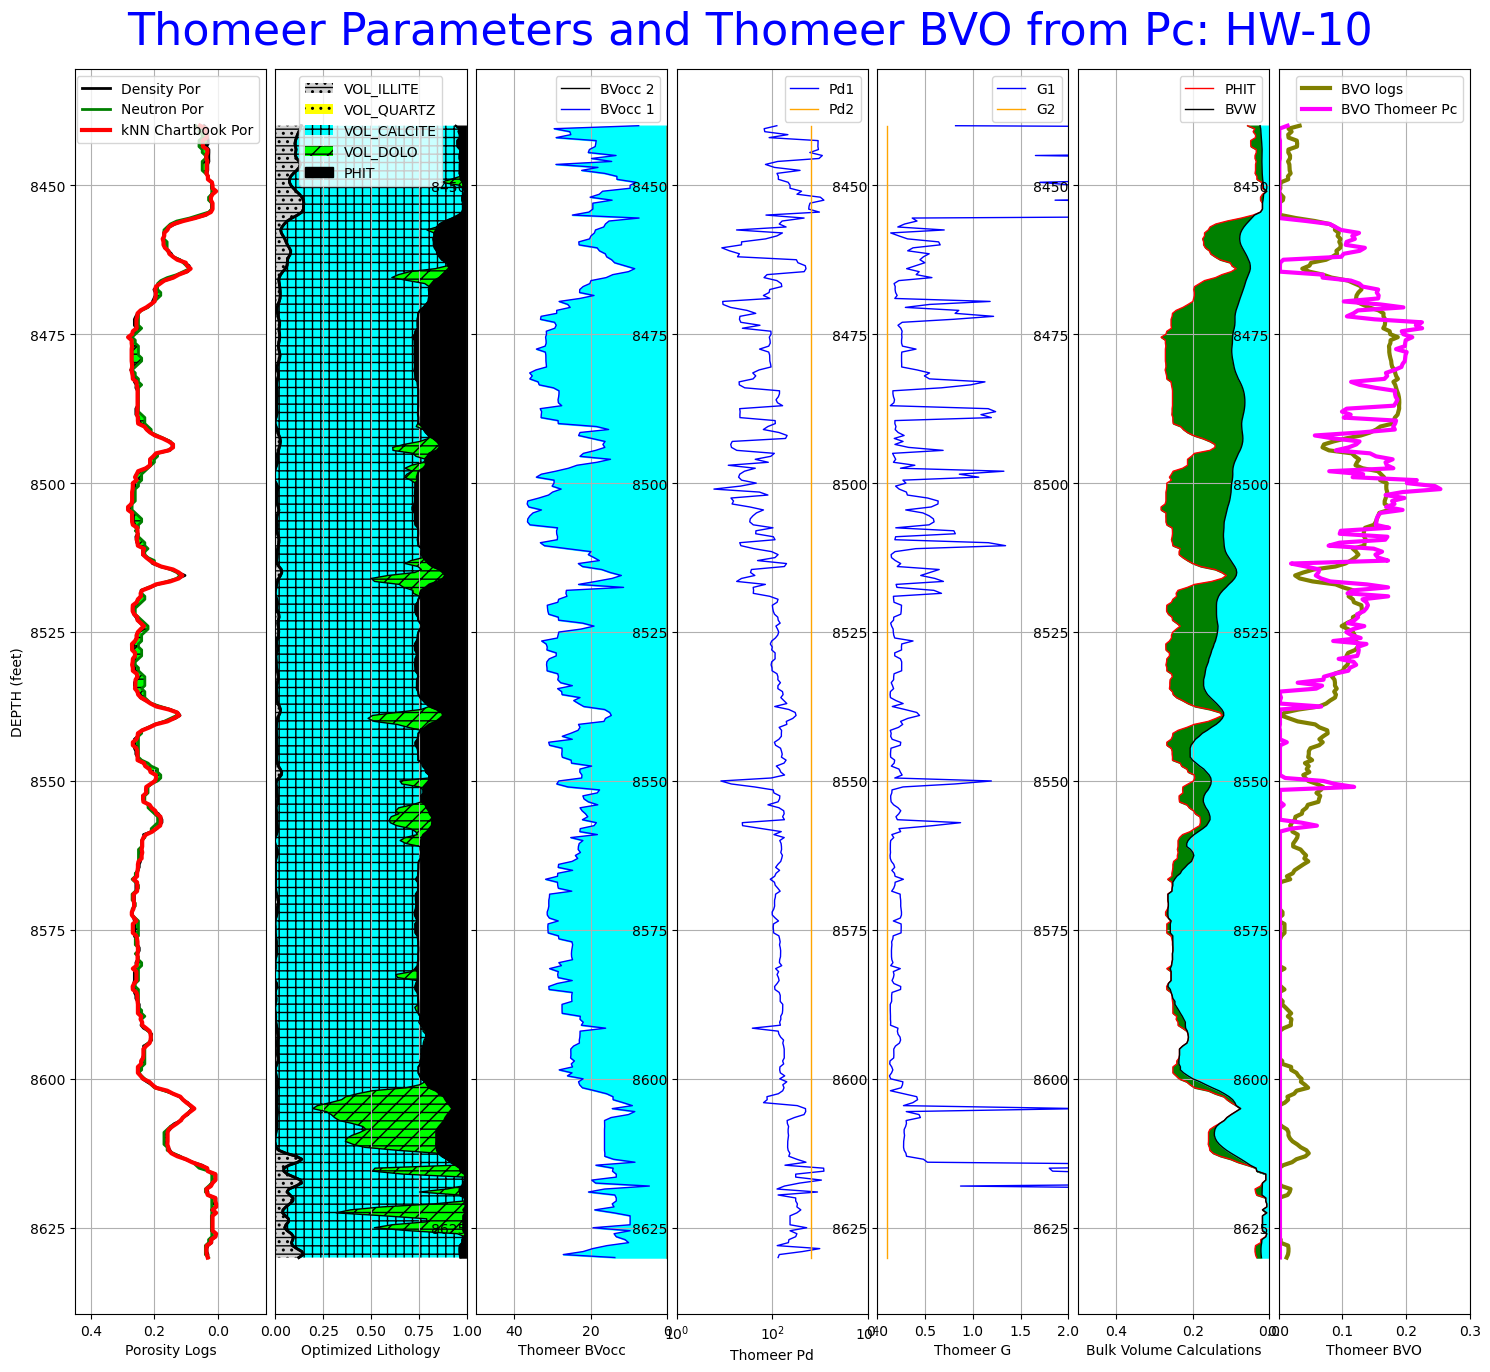

In [67]:
h=[]
PcRes=[]
PcHg=[]
por_upscale_fact=[]
bvocc1=[]
bvocc2=[]
bvo_thomeer=[]
sw_thomeer=[]


fwl=fwl_est
#fwl=8200
#elev_meas_ref = 397


# Load log data from df
for k in range(0,len(df_log) ,1):  

    # =============================================================================
    # # ===========================================================================
    # # #--------------------------------------------------------------------------
    # # #
    # # #            Calculate Thomeer-based BVO Saturations
    # # #
    # # #--------------------------------------------------------------------------
    # # ===========================================================================
    # =============================================================================

    h.append(fwl - (Dep[k]-elev_meas_ref))  #Works Well
  
      
    PcRes.append(h[k] *0.433*(rho_f - rho_hc))
    PcHg.append((367/tcosthetaww)*PcRes[k])   

    #------------- Thomeer Upscale Porosity Correction Factor  ------------------------
          
    bv1=bv1_est_knn[k]/100
    bv2=bv2_est_knn[k]/100

    if porarray[k] > 0.01:
        por_upscale_fact.append((0.1629 * math.log(porarray[k]) + 1.2923) * (porarray[k]/(bv1+bv2)) )
    else:
        por_upscale_fact.append(0.55)
   
    #------- End of Thomeer Porosity Upscale Correction Factor---------------------------
         
         
           
    #---------------  Calculalte Bulk Volume Occupied at each well-level ----------------
    if PcHg[k] > pd1_est_knn[k]:
        #bvocc1 = bv1*bv_upscale_fact * 10**(-0.434*g1/math.log10(((367/tcosthetaww)*h*0.433*(rho_f - rho_hc))/pd1))
        bvocc1.append(bv1*por_upscale_fact[k]*10**(-0.434*g1_est_knn[k]/math.log10(PcHg[k]/pd1_est_knn[k]))) 
     
    else:
        bvocc1.append(0.001)

    if PcHg[k] > pd2_est_knn[k]:
        #bvocc2 = bv2*bv_upscale_fact * 10**(-0.434*g2/math.log10(((367/tcosthetaww)*h*0.433*(rho_f - rho_hc))/pd2))
        bvocc2.append(bv2*por_upscale_fact[k]*10**(-0.434*g2_est_knn[k]/math.log10(PcHg[k]/pd2_est_knn[k]))) 
    else:
        bvocc2.append(0.001)

 

    #---------   Calculate BVO and Sw  ------------------------------------------------
    bvo_thomeer.append( bvocc1[k]  + bvocc2[k])
    sw_thomeer.append(1 - bvo_thomeer[k]/porarray[k])

    #print(porarray[k],bvocc1[k],bvocc2[k],bvo_thomeer[k],sw_thomeer[k])
    
    
    
print(fwl,len(bvocc1),len(bvocc2), len(bvocc2),len(sw_thomeer))


'''
# =============================================================================
#      Display BVO from Thomeer and FWL Search 
# ============================================================================='''
BVO_plot()

# 7) Export Results:

In [68]:
# Header line
print('Depth','\t','PHIT','\t','BVO','\t','Pd1','\t','Pd2','\t','\t','G1','\t','G2','\t','BV1','\t','BV2','\t','Perm')

# level-by-level data
for k in range(10,len(df_log) ,1):  

    print(Dep[k],'\t',round(porarray[k],2),'\t',round(bvo_thomeer[k],2), \
          '\t',round(pd1_est_knn[k],0),'\t',round(pd2_est_knn[k],0),'\t','\t',round(g1_est_knn[k],2), \
          '\t',round(g2_est_knn[k],2), '\t',round(bv1_est_knn[k],1), \
          '\t',round(bv2_est_knn[k],1), '\t',round(perm[k],2)    ) 


Depth 	 PHIT 	 BVO 	 Pd1 	 Pd2 	 	 G1 	 G2 	 BV1 	 BV2 	 Perm
8445.0 	 0.04 	 0.0 	 1116.0 	 650 	 	 1.65 	 0.1 	 13.4 	 0 	 0.14
8445.5 	 0.04 	 0.0 	 952.0 	 650 	 	 3.6 	 0.1 	 19.8 	 0 	 0.1
8446.0 	 0.03 	 0.0 	 130.0 	 650 	 	 3.27 	 0.1 	 14.5 	 0 	 0.01
8446.5 	 0.04 	 0.0 	 72.0 	 650 	 	 7.07 	 0.1 	 29.1 	 0 	 0.02
8447.0 	 0.04 	 0.0 	 111.0 	 650 	 	 4.17 	 0.1 	 18.1 	 0 	 0.01
8447.5 	 0.04 	 0.0 	 381.0 	 650 	 	 5.05 	 0.1 	 22.4 	 0 	 0.04
8448.0 	 0.04 	 0.0 	 126.0 	 650 	 	 3.71 	 0.1 	 16.4 	 0 	 0.01
8448.5 	 0.03 	 0.0 	 134.0 	 650 	 	 2.93 	 0.1 	 13.1 	 0 	 0.01
8449.0 	 0.03 	 0.0 	 134.0 	 650 	 	 2.93 	 0.1 	 13.1 	 0 	 0.01
8449.5 	 0.02 	 0.0 	 215.0 	 650 	 	 1.7 	 0.1 	 8.2 	 0 	 0.01
8450.0 	 0.02 	 0.0 	 235.0 	 650 	 	 2.06 	 0.1 	 9.7 	 0 	 0.01
8450.5 	 0.02 	 0.0 	 235.0 	 650 	 	 2.06 	 0.1 	 9.7 	 0 	 0.01
8451.0 	 0.01 	 0.0 	 409.0 	 650 	 	 3.66 	 0.1 	 16.9 	 0 	 0.02
8451.5 	 0.02 	 0.0 	 329.0 	 650 	 	 3.96 	 0.1 	 17.8 	 0 	 0.02
8452.0

### This section will write out the above text data to a file called 'results.txt':

In [69]:
import sys

original_stdout = sys.stdout # Save a reference to the original standard output

with open('results.txt', 'w') as f:
    sys.stdout = f # Change the standard output to the file we created.

    # Header line
    print('Depth','\t','PHIT','\t','BVO','\t','Pd1','\t','Pd2','\t','\t','G1','\t','G2','\t','BV1','\t','BV2','\t','Perm')
    
    # level-by-level data
    for k in range(10,len(df_log) ,1):  

        print(Dep[k],'\t',round(porarray[k],2),'\t',round(bvo_thomeer[k],2), \
              '\t',round(pd1_est_knn[k],0),'\t',round(pd2_est_knn[k],0),'\t','\t',round(g1_est_knn[k],2), \
              '\t',round(g2_est_knn[k],2), '\t',round(bv1_est_knn[k],1), \
              '\t',round(bv2_est_knn[k],1), '\t',round(perm[k],2)    ) 
    
    sys.stdout = original_stdout # Reset the standard output to its original value





## The next section will create a DataFrame for our results data:

In [70]:
results=[Dep ,porarray,rhoarray,bvo_thomeer,sw_thomeer, VOL_QUARTZ,VOL_CALCITE,VOL_DOLO,VOL_ILLITE,pd1_est_knn, pd2_est_knn, g1_est_knn, g2_est_knn,bv1_est_knn, bv2_est_knn, perm, rock_index_knn] 
results_transpose = np.transpose(results)


#results=[                                            Dep ,porarray,rhoarray,  bvo_thomeer,sw_thomeer, VOL_QUARTZ,VOL_CALCITE,VOL_DOLO,VOL_ILLITE,      pd1_est_knn, pd2_est_knn, g1_est_knn, g2_est_knn,bv1_est_knn, bv2_est_knn, perm, rock_index_knn] 
df_results=pd.DataFrame(results_transpose, columns = ['DEPT' ,'PHIT','Rho_Matrix','BVO_Thomeer','Sw_Thomeer',        'Vol_Quartz','Vol_Calcite','Vol_dolo','Vol_Illite','Pd1_knn', 'Pd2_knn',      'G1_knn', 'G2_knn',    'BV1_knn', 'BV2_knn',  'Perm_knn','ROCK_INDEX'])

#df_reset=df_results.reset_index(drop=True)
df_results.reset_index(drop=True)
df_results.head()

,DEPT,PHIT,Rho_Matrix,BVO_Thomeer,Sw_Thomeer,Vol_Quartz,Vol_Calcite,Vol_dolo,Vol_Illite,Pd1_knn,Pd2_knn,G1_knn,G2_knn,BV1_knn,BV2_knn,Perm_knn,ROCK_INDEX
0,8440.0,0.056559,2.804794,0.013923,0.753832,0.0,0.806896,0.000943,0.135601,124.570284,650.0,0.818554,0.1,7.460537,0.0,0.697248,1.0
1,8440.5,0.037629,2.786119,0.001010,0.973164,0.0,0.831711,0.000962,0.129698,67.615614,650.0,7.192138,0.1,29.581591,0.0,0.018942,3.0
2,8441.0,0.041813,2.781216,0.001035,0.975247,0.0,0.834502,0.000958,0.122726,69.706458,650.0,6.058887,0.1,25.473014,0.0,0.020753,3.0
3,8441.5,0.035585,2.784445,0.001000,0.971898,0.0,0.848146,0.000964,0.115305,212.127949,650.0,5.942048,0.1,25.207486,0.0,0.028167,3.0
4,8442.0,0.035585,2.784445,0.001004,0.971794,0.0,0.853488,0.000964,0.109963,85.865830,650.0,7.042268,0.1,29.061387,0.0,0.022397,3.0


### This is our original DataFrame from reading in the las file and converting to a DataFrame:

In [71]:
df_log.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 381 entries, 8440.0 to 8630.0
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   GR         381 non-null    float64
 1   RHOB       381 non-null    float64
 2   NPHI       381 non-null    float64
 3   DT         0 non-null      float64
 4   PHIE       381 non-null    float64
 5   RT         381 non-null    float64
 6   SW         160 non-null    float64
 7   SO         160 non-null    float64
 8   CORE_POR   311 non-null    float64
 9   CORE_PERM  311 non-null    float64
dtypes: float64(10)
memory usage: 32.7 KB


### This section will merge the two Pandas DataFrames:
**df_log from original las file and the new df_results DataFrames are used**

In [72]:
file_out = pd.merge(df_log, df_results ,how="left", on=["DEPT", "DEPT"])
#file_out.reset_index(drop=True)
#df_file_out=las.file_out().reset_index()
#file_out=file_out.iloc[:,0:]
#del file_out[file_out.columns[0]]

In [73]:
file_out.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 381 entries, 0 to 380
Data columns (total 27 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   DEPT         381 non-null    float64
 1   GR           381 non-null    float64
 2   RHOB         381 non-null    float64
 3   NPHI         381 non-null    float64
 4   DT           0 non-null      float64
 5   PHIE         381 non-null    float64
 6   RT           381 non-null    float64
 7   SW           160 non-null    float64
 8   SO           160 non-null    float64
 9   CORE_POR     311 non-null    float64
 10  CORE_PERM    311 non-null    float64
 11  PHIT         381 non-null    float64
 12  Rho_Matrix   381 non-null    float64
 13  BVO_Thomeer  381 non-null    float64
 14  Sw_Thomeer   381 non-null    float64
 15  Vol_Quartz   381 non-null    float64
 16  Vol_Calcite  381 non-null    float64
 17  Vol_dolo     381 non-null    float64
 18  Vol_Illite   381 non-null    float64
 19  Pd1_knn 

### This will write out an Excel file of the Petrophysical Analysis for the well:

In [74]:
for item in las.well:
    print(f"{item.descr} ({item.mnemonic}): {item.value}")

 (STRT): 8150.0
 (STOP): 8630.0
 (STEP): 0.5
 (NULL): -999.25
COMPANY (COMP): 
WELL (WELL): HW-10
FIELD (FLD): COSTA
LOCATION (LOC): 
SERVICE COMPANY (SRVC): 
ss} (DATE): 2018-02-06 14:55:39   : Log Export Date {yyyy-MM-dd HH:mm
PROVINCE (PROV): 
UNIQUE WELL ID (UWI): HW-10
API NUMBER (API): 


In [75]:
print(las.well.well.value)

HW-10


In [76]:
directory = "./results/Petrophysial_analysis_"
wellname=las.well.well.value
ext='.xlsx'
filepath =  directory  + wellname + ext
file_out.to_excel(filepath)

## **Write file_out to las following the code from Andy McDonald's method to convert csv to las**

**Watch Andy's YouTube presentation on this:**

https://www.youtube.com/watch?v=GwAbfriuHr4


In [77]:
las_file = lasio.LASFile()

In [78]:
las_file.header

{'Version': [HeaderItem(mnemonic="VERS", unit="", value="2.0", descr="CWLS log ASCII Standa"),
  HeaderItem(mnemonic="WRAP", unit="", value="NO", descr="One line per depth ste"),
  HeaderItem(mnemonic="DLM", unit="", value="SPACE", descr="Column Data Section ")],
 'Well': [HeaderItem(mnemonic="STRT", unit="m", value="nan", descr="START DEPTH"),
  HeaderItem(mnemonic="STOP", unit="m", value="nan", descr="STOP DEPTH"),
  HeaderItem(mnemonic="STEP", unit="m", value="nan", descr="STEP"),
  HeaderItem(mnemonic="NULL", unit="", value="-9999.25", descr="NULL VALUE"),
  HeaderItem(mnemonic="COMP", unit="", value="", descr="COMPANY"),
  HeaderItem(mnemonic="WELL", unit="", value="", descr="WELL"),
  HeaderItem(mnemonic="FLD", unit="", value="", descr="FIELD"),
  HeaderItem(mnemonic="LOC", unit="", value="", descr="LOCATION"),
  HeaderItem(mnemonic="PROV", unit="", value="", descr="PROVINCE"),
  HeaderItem(mnemonic="CNTY", unit="", value="", descr="COUNTY"),
  HeaderItem(mnemonic="STAT", unit=""

In [79]:
well_name = las.well.well.value
field_name = las.well.fld.value
uwi = las.well.uwi.value

In [80]:
print('Well Name =',well_name, ', Field Name =', field_name, ', UWI =',uwi)

Well Name = HW-10 , Field Name = COSTA , UWI = HW-10


In [81]:
las_file.well['WELL'] = lasio.HeaderItem('WELL',value=las.well.well.value)
las_file.well['FLD'] = lasio.HeaderItem('FLD',value=las.well.fld.value)
las_file.well['UWI'] = lasio.HeaderItem('UWI',value=las.well.uwi.value)

In [82]:
las_file.header

{'Version': [HeaderItem(mnemonic="VERS", unit="", value="2.0", descr="CWLS log ASCII Standa"),
  HeaderItem(mnemonic="WRAP", unit="", value="NO", descr="One line per depth ste"),
  HeaderItem(mnemonic="DLM", unit="", value="SPACE", descr="Column Data Section ")],
 'Well': [HeaderItem(mnemonic="STRT", unit="m", value="nan", descr="START DEPTH"),
  HeaderItem(mnemonic="STOP", unit="m", value="nan", descr="STOP DEPTH"),
  HeaderItem(mnemonic="STEP", unit="m", value="nan", descr="STEP"),
  HeaderItem(mnemonic="NULL", unit="", value="-9999.25", descr="NULL VALUE"),
  HeaderItem(mnemonic="COMP", unit="", value="", descr="COMPANY"),
  HeaderItem(mnemonic="WELL", unit="", value="HW-10", descr=""),
  HeaderItem(mnemonic="FLD", unit="", value="COSTA", descr=""),
  HeaderItem(mnemonic="LOC", unit="", value="", descr="LOCATION"),
  HeaderItem(mnemonic="PROV", unit="", value="", descr="PROVINCE"),
  HeaderItem(mnemonic="CNTY", unit="", value="", descr="COUNTY"),
  HeaderItem(mnemonic="STAT", unit="

In [83]:
las_file.add_curve('DEPT',file_out['DEPT'],unit='ft')

In [84]:
las_file.curves

[CurveItem(mnemonic="DEPT", unit="ft", value="", descr="", original_mnemonic="DEPT", data.shape=(381,))]

In [85]:
directory_las = "./results/Petrophysical_analysis_"
wellname=las.well.well.value
ext_las='.las'
filepath_las =  directory_las  + wellname + ext_las
#file_out.to_excel(filepath)

In [86]:
units=['ft',
       'GAPI',
       'G/C3',
       'V/V',
       'US/F',
       'V/V',
       'OHMM',
       'V/V',
       'V/V',
       '%',
       'mD' ,
       'V/V',
       'G/C3',
       'V/V',
       'V/V',
       'V/V',
       'V/V',
       'V/V',
       'V/V',
       'psi',
       'psi',
       '',
       '',
       '%',
       '%',
       'mD',
       '']


In [87]:
for col, unit in zip(file_out.columns,units):
    if col !='DEPT':
        las_file.add_curve(col,file_out[col], unit=unit)

In [88]:
las_file.curves

[CurveItem(mnemonic="DEPT", unit="ft", value="", descr="", original_mnemonic="DEPT", data.shape=(381,)),
 CurveItem(mnemonic="GR", unit="GAPI", value="", descr="", original_mnemonic="GR", data.shape=(381,)),
 CurveItem(mnemonic="RHOB", unit="G/C3", value="", descr="", original_mnemonic="RHOB", data.shape=(381,)),
 CurveItem(mnemonic="NPHI", unit="V/V", value="", descr="", original_mnemonic="NPHI", data.shape=(381,)),
 CurveItem(mnemonic="DT", unit="US/F", value="", descr="", original_mnemonic="DT", data.shape=(381,)),
 CurveItem(mnemonic="PHIE", unit="V/V", value="", descr="", original_mnemonic="PHIE", data.shape=(381,)),
 CurveItem(mnemonic="RT", unit="OHMM", value="", descr="", original_mnemonic="RT", data.shape=(381,)),
 CurveItem(mnemonic="SW", unit="V/V", value="", descr="", original_mnemonic="SW", data.shape=(381,)),
 CurveItem(mnemonic="SO", unit="V/V", value="", descr="", original_mnemonic="SO", data.shape=(381,)),
 CurveItem(mnemonic="CORE_POR", unit="%", value="", descr="", o

In [89]:
las_file.write(filepath_las,version=2.0)

## Time to run entire program if using >> which is Restart Kernel and Run All Cells:

**On a Mac M1 Pro this takes around 20 seconds to run the complete process.**

In [90]:
timecosts = (time.time() - s_time)
print(f'time: {np.mean(timecosts):.5f}s',time.asctime( time.localtime(time.time()) ))

time: 221.22597s Tue Mar 14 19:00:47 2023
